In [ ]:
from collections import deque
from itertools import chain
import heapq as hq
import numpy as np

rng = np.random.default_rng(seed=42)

class Trade: 
    def __init__(self, bid_order, ask_order, price, volume):
        self.bid_order = bid_order
        self.ask_order = ask_order
        self.price = price
        self.volume = volume
    
    def __repr__(self):
        return f"Trade(bid_id={self.bid_order.id}, ask_id={self.ask_order.id}, price={self.price}, volume={self.volume})"
    
class Order: 
    _id_counter = 0 

    def __init__(self, price=None, volume=100, is_bid=True, is_market=False, trader_id=None, lifetime=None):
        self.price = price 
        self.volume = volume 
        self.is_bid = is_bid
        self.id = Order._id_counter
        self.is_market = is_market
        self.trader_id = trader_id
        self.lifetime = lifetime

        Order._id_counter += 1
    
    def __repr__(self):
        side = "BID" if self.is_bid else "ASK"
        type_ = "MARKET" if self.is_market else "LIMIT"
        return f"Order(id={self.id}, price={self.price}, volume={self.volume}, side={side}, type={type_}, trader_id={self.trader_id})"
    
class MarketOrder(Order):

    def __init__(self, volume=100, is_bid=True, trader_id=None):
        price = float('inf') if is_bid else -float('inf')
        super().__init__(price, volume, is_bid, is_market=True, trader_id=trader_id)



In [193]:
class ExpirationWheel:
    def __init__(self, min_lifetime, max_lifetime):
        self.max_lifetime = max_lifetime
        self.min_lifetime = min_lifetime
        self.expiration_bucket = [[] for _ in range(max_lifetime)]
        self.now = 0

    def schedule(self, order):
        lifetime = order.lifetime if order.lifetime is not None else self.min_lifetime
        expiration = (self.now + lifetime) % self.max_lifetime
        self.expiration_bucket[expiration].append(order.id)

    def advance(self):
        self.now = (self.now + 1) % self.max_lifetime
        expired = self.expiration_bucket[self.now]
        self.expiration_bucket[self.now] = []
        return expired

In [194]:
class PriceLevel:
    def __init__(self, price):
        self.price = price 
        self.orders = deque()
    
    def add(self, order):
        self.orders.append(order)

    def top(self):
        if not self.orders:
            return None
        return self.orders[0] # O(1)

    def pop(self):
        if not self.orders:
            raise IndexError("Price level is empty.")
        return self.orders.popleft() # O(1)
    
    def fill(self, order):
        trades = []
        level_orders_filled = []
        is_bid = order.is_bid

        while not self.is_empty() and order.volume > 0: 
            top_order = self.top()
            trade_volume = 0

            if top_order.volume > order.volume: 
                trade_volume += order.volume

            elif top_order.volume == order.volume: 
                trade_volume += order.volume
                level_orders_filled.append(self.pop())
                
            else: 
                trade_volume += top_order.volume
                level_orders_filled.append(self.pop())

            # Update order volumes
            top_order.volume -= trade_volume 
            order.volume -= trade_volume 
            
            # Log trade
            bid = order if is_bid else top_order
            ask = top_order if is_bid else order
            trade = Trade(bid, ask, self.price, trade_volume)
            trades.append(trade)

        return trades, level_orders_filled
        
    def cancel(self, order):
        try:
            self.orders.remove(order) # O(n)
        except ValueError:
            raise ValueError("Order not found at this price level.")
        
    def is_empty(self):
        return True if len(self.orders) == 0 else False
    
    def get_stats(self):
        volume = sum(order.volume for order in self.orders)
        return {
            "price" : self.price, 
            "volume" : volume,
            "n orders" : len(self.orders)
        }
    
    def __repr__(self):
        return f"PriceLevel(price={self.price}, orders={list(self.orders)})"
    
    def __str__(self):
        volume = sum(order.volume for order in self.orders)
        return f"PriceLevel: Price={self.price}, Volume={volume}, Orders={len(self.orders)}"


In [195]:
class PriceBook:
    def __init__(self, is_bid_side):
        self.order_map = {}
        self._price_levels = {}
        self._heap = []
        self.is_bid_side = is_bid_side

    def add(self, order): 
        price = order.price

        if price not in self._price_levels:
            # Add price level to heap
            self._price_levels[price] = PriceLevel(price)
            # Use negative price for max-heap behavior on bid side.
            heap_price = -price if self.is_bid_side else price
            hq.heappush(self._heap, heap_price)

        # Add order to price level 
        self._price_levels[price].add(order)
        # Add order to the order map 
        self.order_map[order.id] = order

    
    def cancel(self, order):
        price = order.price
        if price not in self._price_levels:
            raise ValueError(f"Price {price} not found in PriceBook.")

        try:
            self._price_levels[price].cancel(order)
            # Trying to remove the price level from the heap here would be O(N) so we delay clean up
        except ValueError as e:
            # Propagate the original error
            raise ValueError(f"Failed to cancel order {order.id}: {e}") from e
        
        # Remove from order map
        del self.order_map[order.id]

    def best_price(self):
        if not self._price_levels: 
            return None
        else:
            # Since I didn't remove empty price levels upon order cancellation I have to handle it here
            while self._heap:
                best_price = - self._heap[0] if self.is_bid_side else self._heap[0]
                # Remove empty price levels
                if self._price_levels[best_price].is_empty():
                    hq.heappop(self._heap)
                    del self._price_levels[best_price]
                else: 
                    break

            if self._heap:
                return best_price
            else:
                return None
        
    def fill(self, order):
        if order.is_bid == self.is_bid_side:
            raise ValueError("Cannot fill an order on the same side of the PriceBook.")
        
        price = order.price
        trades = []
        best_price = self.best_price()

        while best_price and order.volume > 0:
            
            # Check whether prices are compatible
            can_fill = (best_price >= price) if self.is_bid_side else (best_price <= price)

            if can_fill:
                trades_at_price, orders_filled = self._price_levels[best_price].fill(order)
                trades.extend(trades_at_price)
                for o in orders_filled:
                    try:
                        del self.order_map[o.id]
                    except KeyError as e:
                        raise KeyError(f"Tried to delete order {e} from the order_map. It is probably a duplicate order.")
                    
            else:
                break
            
            # This simultaneously removes empty price levels and establishes next best_price
            best_price = self.best_price()

        # Return list of trades
        return trades
    
    def get_stats_l2(self):
        price_volume = {}
        for heap_price in sorted(self._heap, reverse= not self.is_bid_side):
            price = -heap_price if self.is_bid_side else heap_price
            price_level = self._price_levels[price]
            stats = price_level.get_stats()
            volume = stats["volume"]
            price_volume[price] = volume 

        return {
            "Side": ("Bid" if self.is_bid_side else "ASK"),
            "Price-Volume": price_volume
        }
    
    def __repr__(self):
        return f"PriceBook(is_bid_side={self.is_bid_side}, price_levels={sorted(list(self._price_levels.keys()))})"
    
    def display(self):
        print(f"{'BID' if self.is_bid_side else 'ASK'} PriceBook:")
        for heap_price in sorted(self._heap, reverse= not self.is_bid_side):
            price = -heap_price if self.is_bid_side else heap_price
            price_level = self._price_levels[price]
            print(price_level)

In [196]:
class Asset:
    def __init__(self, initial_value=100):
        self.initial_value = initial_value
        self.value = initial_value

    def evolve_value(self, drift=0, sigma=0.5):
        self.value += rng.normal(drift, sigma)

    def __repr__(self):
        return f"Asset(value={self.value})"
    
    def __str__(self):
        return f"Current Value: {self.value}, Initial Value: {self.initial_value}"
    
class TradesNotification:
    def __init__(self, order):
        self.trader_id = order.trader_id
        self.order_id = order.id
        self.is_bid = order.is_bid

        self.price_volume = {}
        self.counter_party_volume = {}
        self.num_trades = 0

        self._remaining_volume = order.volume
        self.is_filled = True if order.volume == 0 else False

    @property
    def average_price(self):
        return self.total_notional / self.total_filled_volume 
    
    @property 
    def total_filled_volume(self):
        return sum(self.price_volume.values())
    
    @property
    def total_notional(self):
        return sum(price * volume for price, volume in self.price_volume.items())

    def add_trade(self, trade):
        self.price_volume[trade.price] = self.price_volume.get(trade.price, 0) + trade.volume
        self.num_trades += 1
        if self.is_bid:
            cp_id = trade.ask_order.trader_id
        else:
            cp_id = trade.bid_order.trader_id
        self.counter_party_volume[cp_id] = self.counter_party_volume.get(cp_id, 0) + trade.volume
        return self
    
    def __repr__(self):
        status = "FILLED" if self.is_filled else "PARTIAL"
        return (f"TradesNotification(order_id={self.order_id}, "
                f"filled {self.total_filled_volume}@{self.average_price:.2f} avg, "
                f"{self.num_trades} trades, remaining={self._remaining_volume}, {status})")
    
    def __str__(self):
        status = "FILLED \u2713" if self.is_filled else "PARTIAL"
        return (f"order_id:{self.order_id}, \n"
                f"filled {self.total_filled_volume}@{self.average_price:.2f} avg, \n"
                f"{self.num_trades} trades, remaining:{self._remaining_volume}, {status}")
    

In [197]:
class OrderBook:

    def __init__(self, min_lifetime=3, max_lifetime=1000):
        self.bids = PriceBook(is_bid_side=True)
        self.asks = PriceBook(is_bid_side=False)
        self.expiration_wheel = ExpirationWheel(min_lifetime, max_lifetime)

        # Volume per trade cycle (usually a tick)
        self.volume_traded = 0 
    
    @property
    def best_bid(self):
        return self.bids.best_price()
    
    @property
    def best_ask(self):
        return self.asks.best_price()
    
    @property 
    def spread(self):
        if self.best_bid == None or self.best_ask == None:
            return None
        else: 
            return round(self.best_ask-self.best_bid, 2)
    
    @property 
    def mid_price(self):
        if self.best_bid == None or self.best_ask == None:
            return None
        else: 
            return round((self.best_ask + self.best_bid) / 2, 2)
    
    def process_orders(self, orders):
        trades = []
        for order in orders:
            if order.is_bid: 
                trades.extend(self.asks.fill(order))
            else:
                trades.extend(self.bids.fill(order))

            # Only add remaining volume to book if it is a limit order
            if order.volume and not order.is_market:
                self.expiration_wheel.schedule(order)
                if order.is_bid:
                    self.bids.add(order)
                else:
                    self.asks.add(order)
            
        return self._process_trades(trades)

    def _process_trades(self, trades):
        self.volume_traded = 0
        order_notifs = {}
        for trade in trades:
            self.volume_traded += trade.volume
            bid_trader_id = trade.bid_order.trader_id
            ask_trader_id = trade.ask_order.trader_id
            if bid_trader_id is not None:
                bid_order = trade.bid_order
                order_notifs[trade.bid_order.id] = order_notifs.get(trade.bid_order.id, TradesNotification(bid_order)).add_trade(trade)
            if ask_trader_id is not None:
                ask_order = trade.ask_order
                order_notifs[trade.ask_order.id] = order_notifs.get(trade.ask_order.id, TradesNotification(ask_order)).add_trade(trade)
        
        return order_notifs
    
    def unfilled_orders(self, trader_id):
        unfilled_asks = self.asks.order_map.values()
        unfilled_bids = self.bids.order_map.values()
        unfilled_orders = [(order.id, order.price, order.volume) for order in chain(unfilled_asks, unfilled_bids) if order.trader_id == trader_id]
        return unfilled_orders

    def process_cancellations(self, order_ids):
        for order_id in order_ids:
            if order_id in self.bids.order_map:
                order = self.bids.order_map[order_id]
                self.bids.cancel(order)
            elif order_id in self.asks.order_map:
                order = self.asks.order_map[order_id]
                self.asks.cancel(order)
            else:
                # order not on books might have been filled.
                pass
                #raise KeyError(f"Order with id {order_id} could not be found in either side of the order book.")
    
    def get_stats(self): 
        bid_l2 = self.bids.get_stats_l2() 
        ask_l2 = self.asks.get_stats_l2()
        bid_price_vol = bid_l2["Price-Volume"]
        ask_price_vol = ask_l2["Price-Volume"]
        total_bid_depth = sum(bid_price_vol.values())
        total_ask_depth = sum(ask_price_vol.values())
        trade_volume = self.volume_traded
        return {
            "Bid L2": bid_price_vol,
            "Ask L2": ask_price_vol,
            "Bid Depth": total_bid_depth,
            "Ask Depth": total_ask_depth,
            "One Tick Traded Volume": trade_volume,
        }

    
    def __repr__(self):
        return f"OrderBook(bids={self.bids.__repr__()}, asks={self.asks.__repr__()})"
    
    def display(self):
        self.bids.display()
        self.asks.display()

In [198]:
class BackgroundFlow(): 
    def __init__(self, arrival_rate=100, min_volume=10, max_volume=100, info=0.3, ag_noise = 0.1, private_info_coeff=0.8):

        self.arrival_rate = arrival_rate
        self.min_volume = min_volume
        self.max_volume = max_volume

        # Liquidity takers fraction
        self.info = info
        self.ag_noise = ag_noise
        self.pass_noise = 1 - info - ag_noise
        if self.pass_noise < 0:
            raise ValueError("Proportion of aggressive noise and info traders cannot together exceed one.")
        self.private_info_coeff = private_info_coeff
        
    def generate_orders(self, order_book, asset):
        n_orders = rng.poisson(self.arrival_rate)
        orders = []

        # Informed traders 
        if order_book.best_bid is None:
            best_bid = asset.value
        else:
            best_bid = order_book.best_bid
        
        if order_book.best_ask is None:
            best_ask = asset.value
        else:
            best_ask = order_book.best_ask
        
        mid_price = (best_bid + best_ask) / 2

        # We model three types of traders: 
        # - aggressive informed traders (take liquidity in direction of fundamental value)
        # - aggressive noise traders (take liquidity randomly - exogenous reasons)
        # - passive noise traders (provide liquidity randomly - exogenous reasons)
        #   - passive noise traders post limit orders randomly around the mid-price with offset based on spread.
        
        for _ in range(n_orders):
            
            volume = rng.integers(self.min_volume, self.max_volume + 1)
            trader = rng.choice(['info', 'ag_noise', 'pass_noise'], p=[self.info, self.ag_noise, self.pass_noise])

            if trader == 'info':
                # Informed trader
                if asset.value >= mid_price:
                    is_bid = rng.random() < 0.5 + self.private_info_coeff / 2
                else:
                    is_bid = rng.random() >= 0.5 + self.private_info_coeff / 2

                orders.append(MarketOrder(volume, is_bid, 0))

            elif trader == 'ag_noise':
                # Aggressive noise trader
                is_bid = rng.random() < 0.5
                orders.append(MarketOrder(volume, is_bid, 0))
            
            else:
                # Passive noise trader 
                is_bid = rng.random() < 0.5
                spread = max((best_ask - best_bid), 0.01)
                offset = rng.uniform(0.01, 2 * spread)
                price = mid_price - offset if is_bid else mid_price + offset
                orders.append(Order(price, volume, is_bid, False, 0, 3))
        
        return orders


In [199]:
class MarketMaker():
    def __init__(self, strategy):
        self.trader_id = 1
        self.inventory = 0
        self.cash = 0
        self.strategy = strategy

        self.buy_volume = 0 
        self.sell_volume = 0 
    
    def order_update(self, order_book):
        # Generate an order via a strategy 
        orders = self.strategy(self, order_book)
        for order in orders:
            order.trader_id = self.trader_id
        
        cancellations = [unfilled_order[0] for unfilled_order in order_book.unfilled_orders(self.trader_id)]
        
        return orders, cancellations
    
    def process_trades_notifications(self, trades_notifications):
        for trades_notification in trades_notifications:
            if trades_notification.trader_id != self.trader_id:
                raise ValueError("Notification and trader don't match.")
            if trades_notification.is_bid:
                self.inventory += trades_notification.total_filled_volume
                self.cash -= trades_notification.total_notional
                self.buy_volume += (trades_notification.total_filled_volume)
            else:
                self.inventory -= trades_notification.total_filled_volume
                self.cash += trades_notification.total_notional
                self.sell_volume += (trades_notification.total_filled_volume)
    
    def pnl(self, order_book):
        # Mark to market
        unrealised_pnl = order_book.mid_price * self.inventory if order_book.mid_price else None
        total_pnl = self.cash + unrealised_pnl if unrealised_pnl else None
        return total_pnl
    
    def get_stats(self):
        return {
            "Inventory" : self.inventory,
            "Cash" : self.cash
        }

In [200]:
class SimpleMarketMakingStrategy:
    def __init__(self, spread, size, inventory_limit):
        self.size = size
        self.spread = spread
        self.inventory_limit = inventory_limit

    def __call__(self, market_maker, order_book):
        if order_book.mid_price:
            mid_price = order_book.mid_price
        else: 
            # Hard code mid_price (maybe change)
            mid_price = 100
        
        orders = [] 
        if market_maker.inventory <= self.inventory_limit:
            orders.append(Order(mid_price - self.spread / 2, self.size, True, False))
        if market_maker.inventory >= -self.inventory_limit:
            orders.append(Order(mid_price + self.spread / 2, self.size, False, False))

        return orders

Classes: 

### OrderBook classes 

PriceLevel: time Queue priority O(1) add O(n) remove
PriceBook: price priority O(1) add and retrieve (via an id->object map); O(nlogn) remove (heap); 
Expiration_Wheel: tracks which orders should be cancelled at a given timestep 
OrderBook: combination of PriceBook and Price Level + high_level processing logic. 

### Orders and Trades 

Trade: tracks order Ids, trader Ids, price and volume of a given trade
Trade Notification: a summary of trades that compose a single order sent back to traders (so that they can calculate PnL etc.)
Order: self explanatory 

### Market Maker and Order Flow
OrderFlow: generates market orders
MarketMaker: associated with trader id, tracks inventory, cash and processes Trade Notifications and quote updates
MarketMakingStrategy: A simple strategy used by MarketMaker to make quotes called during quote updates. 


Exception ignored When destroying _lsprof profiler:
Traceback (most recent call last):
  File "/var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/299416847.py", line 99, in <module>
RuntimeError: Cannot install a profile function while another profile function is being installed


         41380495 function calls in 20.865 seconds

   Ordered by: cumulative time
   List reduced from 86 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   20.865   10.433 /Users/sebastianodutola/.virtualenvs/LOB/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3663(run_code)
        2    0.000    0.000   20.865   10.433 {built-in method builtins.exec}
        1    0.000    0.000   20.865   20.865 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/299416847.py:1(<module>)
        1    0.220    0.220   20.865   20.865 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/299416847.py:20(simulate)
    10000    8.404    0.001    9.419    0.001 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/26522162.py:16(generate_orders)
    10000    0.615    0.000    8.332    0.001 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/1446298081.py:33(proc

/var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/299416847.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


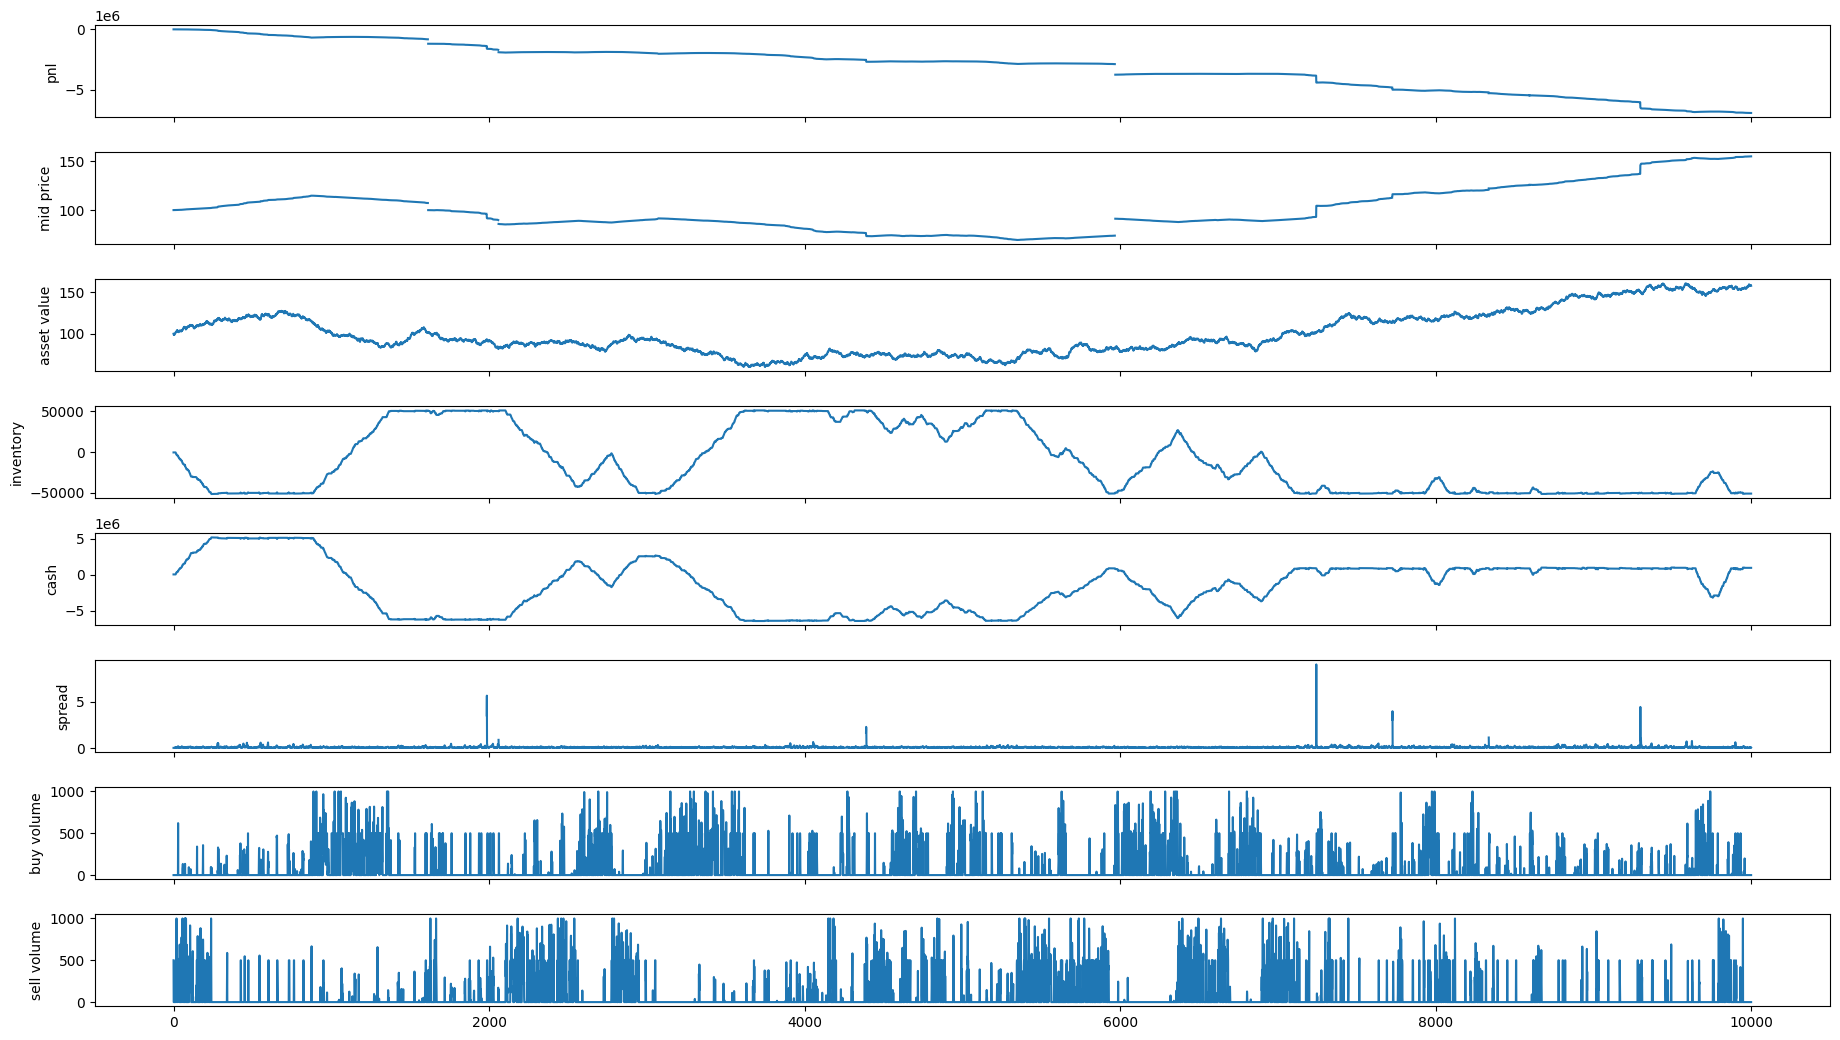

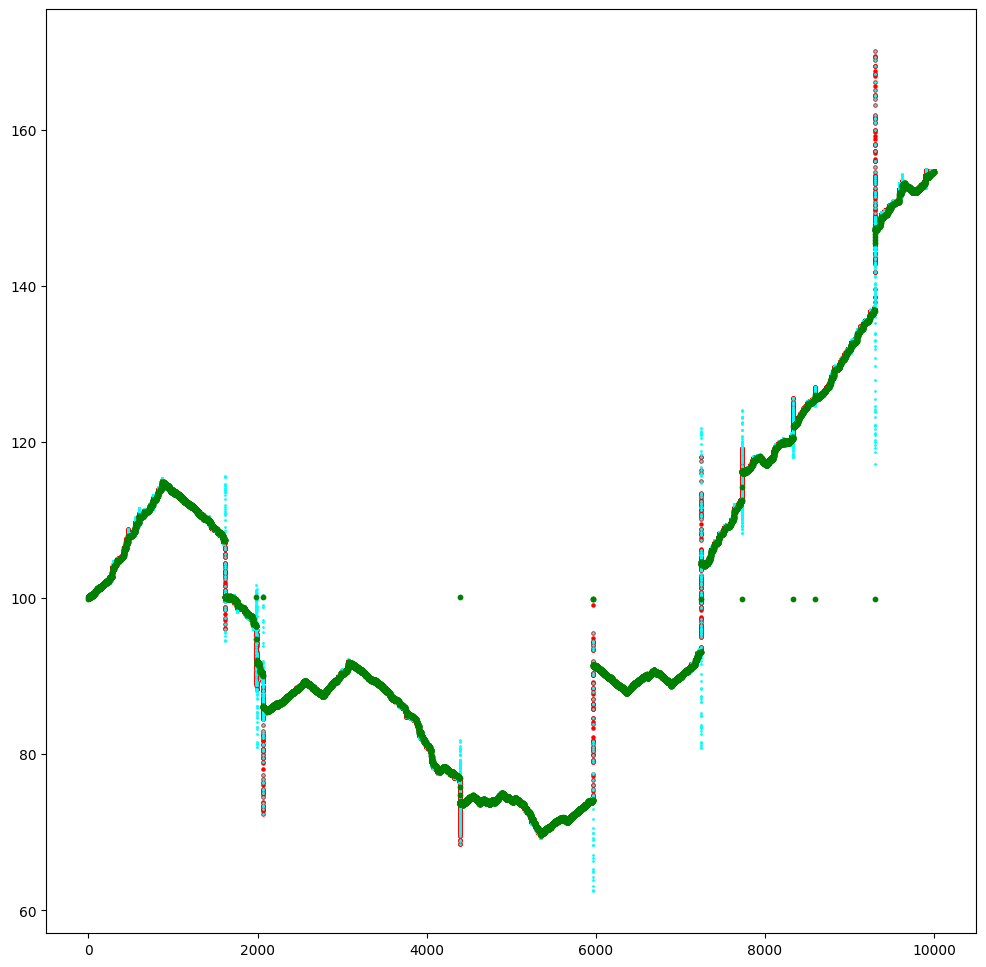

In [201]:
import matplotlib.pyplot as plt
import cProfile 
import pstats

rng = np.random.default_rng(seed=42)
s = Asset()
ob = OrderBook()

mmStrat = SimpleMarketMakingStrategy(0.2, 500, 50000)
mm = MarketMaker(mmStrat)
bf = BackgroundFlow(info=0.2, ag_noise=0.15)

timesteps = 10000

# Visualise orders 
mm_orders = []
noise_orders = []
trade_prices = []

def simulate(mm, bf, ob, timesteps, asset):
    trackers = {
    "pnl" : np.zeros(timesteps),
    "mid price": np.zeros(timesteps),
    "asset value": np.zeros(timesteps),
    "inventory" : np.zeros(timesteps),
    "cash" : np.zeros(timesteps),
    # "ask depth": np.zeros(timesteps),
    # "bid depth": np.zeros(timesteps),
    # "traded volume": np.zeros(timesteps),
    "spread": np.zeros(timesteps),
    "buy volume": np.zeros(timesteps),
    "sell volume": np.zeros(timesteps)
    }

    # cancellations are delayed. {delay: requests}
    delay = 3
    cancel_request = [[] for _ in range(delay+1)]

    for t in range(timesteps):
        # Price Moves 
        asset.evolve_value(drift=0)
        # Expiration Wheel advances
        expirations = ob.expiration_wheel.advance()
        # Expirations are processed 
        ob.process_cancellations(expirations)

        # All Actors place their orders 
        # Problem: cancellation can be shorter than shortest expiration time.
        quotes, cancellations = mm.order_update(ob)
        background_orders = bf.generate_orders(ob, asset)

        # Cancellations requested and processed
        now = t % (delay + 1)
        cancel_time = (t + delay) % (delay + 1)
        cancel_request[cancel_time] = cancellations
        ob.process_cancellations(cancel_request[now])
        cancel_request[now] = []

        # Visualise orders:
        mm_orders.append([quote.price for quote in quotes])
        noise_order_list = [order.price for order in background_orders if order.is_market == False]
        noise_orders.append(noise_order_list)

        # Orders are processed
        trades_notifs = ob.process_orders(chain(background_orders, quotes))
        trade_prices.append([notif.average_price for notif in trades_notifs.values()])

        
        # Process trade notifications for market maker 
        mm_trades_notifs = [trades_notif for _, trades_notif in trades_notifs.items() if trades_notif.trader_id == 1]
        mm.process_trades_notifications(mm_trades_notifs)

        # Calculate pnl
        pnl = mm.pnl(ob)

        # Track
        trackers["pnl"][t] = pnl
        trackers["mid price"][t] = ob.mid_price
        trackers["spread"][t] = ob.spread
        trackers["asset value"][t] = asset.value
        trackers["inventory"][t] = mm.inventory
        trackers["cash"][t] = mm.cash
        trackers["buy volume"][t] = mm.buy_volume
        trackers["sell volume"][t] = mm.sell_volume
        
        mm.buy_volume = 0 
        mm.sell_volume = 0

        # Track Order Book Stats
        # Very Slow Call 
        # ob_stats = ob.get_stats()
        # trackers["ask depth"][t] = ob_stats["Ask Depth"]
        # trackers["bid depth"][t] = ob_stats["Bid Depth"]
        # trackers["traded volume"][t] = ob_stats["One Tick Traded Volume"]
        
    return trackers#, ob_stats

pr = cProfile.Profile()
pr.enable()
trackers = simulate(mm, bf, ob, timesteps, s)
pr.disable()

ps = pstats.Stats(pr).sort_stats('cumtime')
ps.print_stats(20)

fig, axes = plt.subplots(len(trackers), sharex=True)
for i, (k, v) in enumerate(trackers.items()):
    axes[i].plot(v)
    axes[i].set_ylabel(k)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
fig.show()

fig2, ax2 = plt.subplots()
x = [[t]*len(orders_t) for t, orders_t in enumerate(mm_orders)]
y = mm_orders 
x_flat = [p for sublist in x for p in sublist]
y_flat = [p for sublist in y for p in sublist]

x2 = [[t]*len(orders_t) for t, orders_t in enumerate(noise_orders)]
y2 = noise_orders
x2_flat = [x for sublist in x2 for x in sublist]
y2_flat = [y for sublist in y2 for y in sublist]

x3 = [[t]*len(prices) for t, prices in enumerate(trade_prices)]
y3_flat = [y for sublist in trade_prices for y in sublist]
x3_flat = [x for sublist in x3 for x in sublist]

ax2.scatter(x3_flat, y3_flat, s=5, color='red')
ax2.scatter(x2_flat, y2_flat, s=1, color='cyan')
ax2.scatter(x_flat, y_flat, s=10, color='g')

fig2.set_size_inches(12,12)



In [202]:
# Now that our market simulation is working, we try a different market making strategy to see if we can get non-negative PnLs 
class SkewMarketMakingStrategy:
    def __init__(self, spread, size, inventory_limit, skew_coefficient=1e-4):
        self.size = size
        self.spread = spread
        self.inventory_limit = inventory_limit
        self.skew_coefficient = skew_coefficient

    def __call__(self, market_maker, order_book):
        if order_book.mid_price:
            mid_price = order_book.mid_price
        else: 
            # Hard code mid_price (maybe change)
            mid_price = 100
        
        orders = [] 
        exposure = market_maker.inventory * mid_price
        skew = exposure * self.skew_coefficient
        # skew is proportional to inventory 
        if market_maker.inventory <= self.inventory_limit:
            orders.append(Order(mid_price - self.spread - skew / 2, self.size, True, False))
        if market_maker.inventory >= -self.inventory_limit:
            orders.append(Order(mid_price + self.spread - skew / 2, self.size, False, False))

        return orders

         2280194 function calls in 1.082 seconds

   Ordered by: cumulative time
   List reduced from 86 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    1.082    0.541 /Users/sebastianodutola/.virtualenvs/LOB/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3663(run_code)
        2    0.000    0.000    1.082    0.541 {built-in method builtins.exec}
        1    0.000    0.000    1.081    1.081 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/633250297.py:1(<module>)
        1    0.013    0.013    1.081    1.081 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/633250297.py:16(simulate)
      500    0.444    0.001    0.500    0.001 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/26522162.py:16(generate_orders)
      500    0.030    0.000    0.438    0.001 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/1446298081.py:33(proces

/var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/633250297.py:108: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


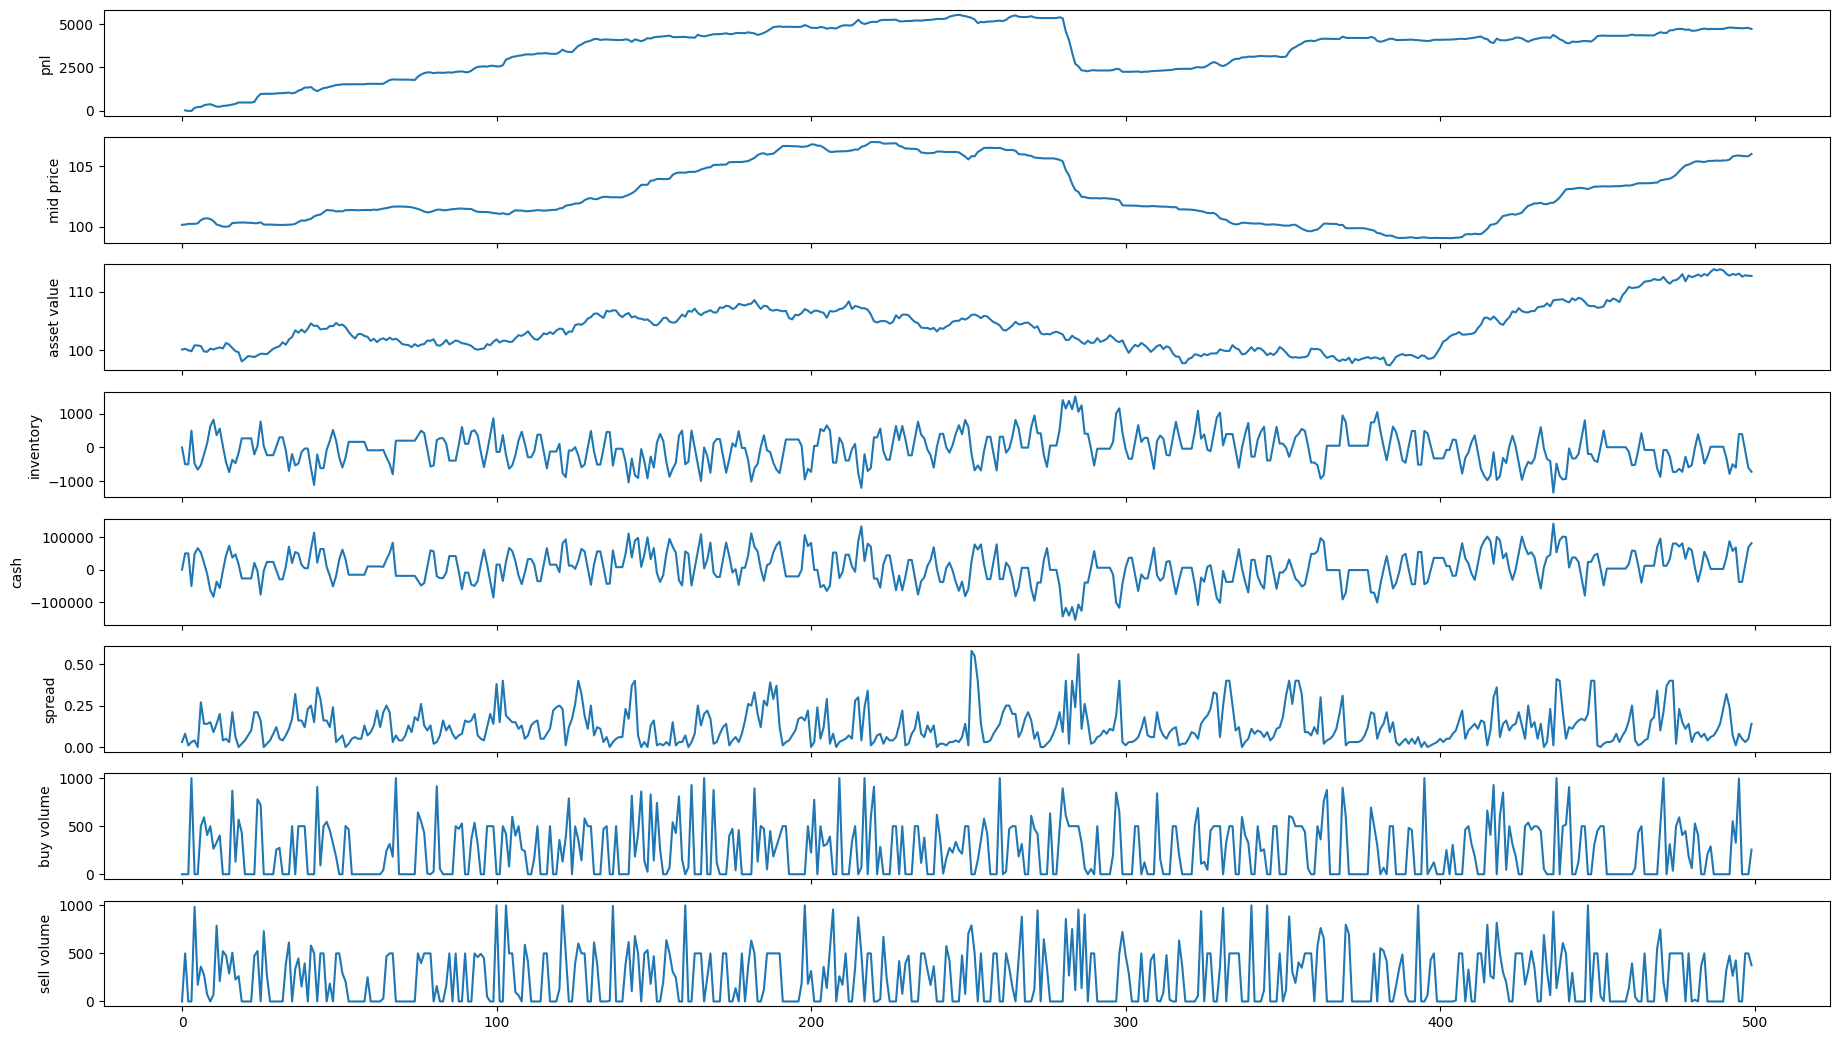

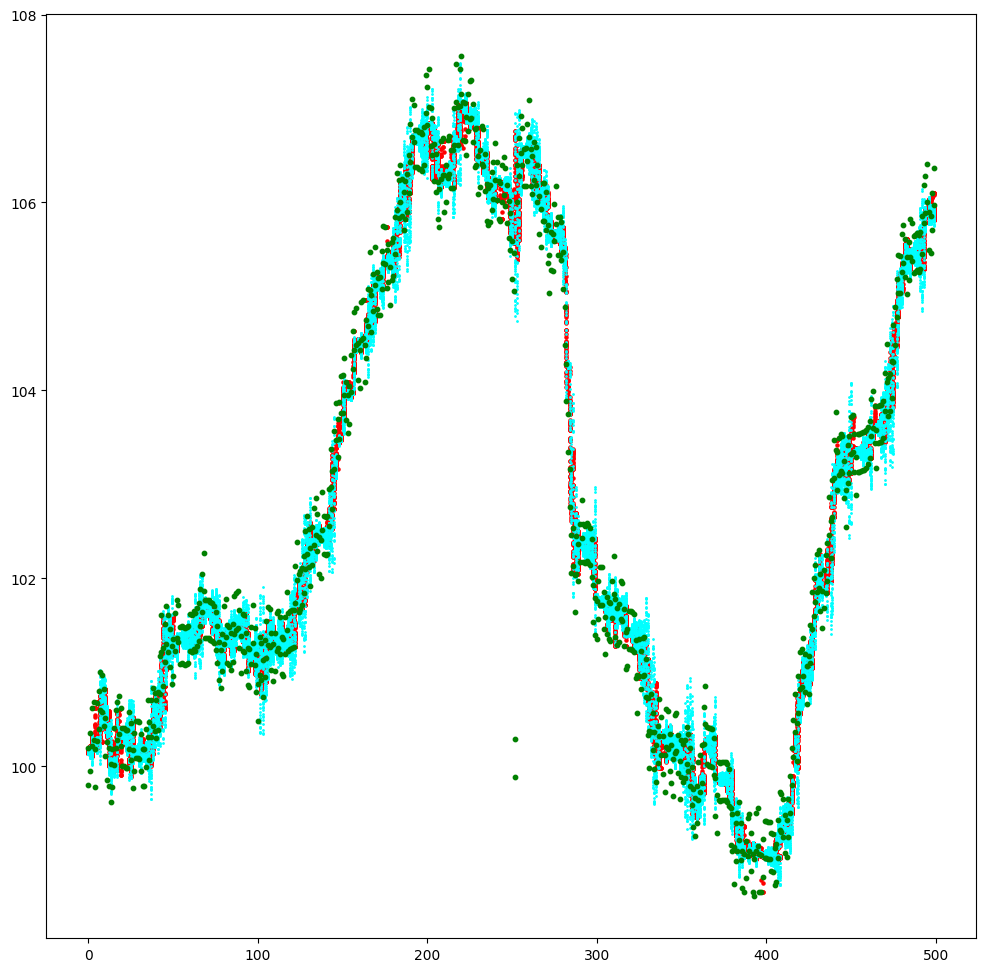

In [203]:
rng = np.random.default_rng(seed=42)
s = Asset()
ob = OrderBook()

mmStrat = SkewMarketMakingStrategy(0.2, 500, 50000, skew_coefficient=1e-5)
mm = MarketMaker(mmStrat)
bf = BackgroundFlow(info=0.3, ag_noise=0.15, private_info_coeff=0.4)

timesteps = 500

# Visualise orders 
mm_orders = []
noise_orders = []
trade_prices = []

def simulate(mm, bf, ob, timesteps, asset):
    trackers = {
    "pnl" : np.zeros(timesteps),
    "mid price": np.zeros(timesteps),
    "asset value": np.zeros(timesteps),
    "inventory" : np.zeros(timesteps),
    "cash" : np.zeros(timesteps),
    # "ask depth": np.zeros(timesteps),
    # "bid depth": np.zeros(timesteps),
    # "traded volume": np.zeros(timesteps),
    "spread": np.zeros(timesteps),
    "buy volume": np.zeros(timesteps),
    "sell volume": np.zeros(timesteps)
    }

    # cancellations are delayed. {delay: requests}
    delay = 3
    cancel_request = [[] for _ in range(delay+1)]

    for t in range(timesteps):
        # Price Moves 
        asset.evolve_value(drift=0)
        # Expiration Wheel advances
        expirations = ob.expiration_wheel.advance()
        # Expirations are processed 
        ob.process_cancellations(expirations)

        # All Actors place their orders 
        # Problem: cancellation can be shorter than shortest expiration time.
        quotes, cancellations = mm.order_update(ob)
        background_orders = bf.generate_orders(ob, asset)

        # Cancellations requested and processed
        now = t % (delay + 1)
        cancel_time = (t + delay) % (delay + 1)
        cancel_request[cancel_time] = cancellations
        ob.process_cancellations(cancel_request[now])
        cancel_request[now] = []

        # Visualise orders:
        mm_orders.append([quote.price for quote in quotes])
        noise_order_list = [order.price for order in background_orders if order.is_market == False]
        noise_orders.append(noise_order_list)

        # Orders are processed
        trades_notifs = ob.process_orders(chain(background_orders, quotes))
        trade_prices.append([notif.average_price for notif in trades_notifs.values()])

        
        # Process trade notifications for market maker 
        mm_trades_notifs = [trades_notif for _, trades_notif in trades_notifs.items() if trades_notif.trader_id == 1]
        mm.process_trades_notifications(mm_trades_notifs)

        # Calculate pnl
        pnl = mm.pnl(ob)

        # Track
        trackers["pnl"][t] = pnl
        trackers["mid price"][t] = ob.mid_price
        trackers["spread"][t] = ob.spread
        trackers["asset value"][t] = asset.value
        trackers["inventory"][t] = mm.inventory
        trackers["cash"][t] = mm.cash
        trackers["buy volume"][t] = mm.buy_volume
        trackers["sell volume"][t] = mm.sell_volume
        
        mm.buy_volume = 0 
        mm.sell_volume = 0

        # Track Order Book Stats
        # Very Slow Call 
        # ob_stats = ob.get_stats()
        # trackers["ask depth"][t] = ob_stats["Ask Depth"]
        # trackers["bid depth"][t] = ob_stats["Bid Depth"]
        # trackers["traded volume"][t] = ob_stats["One Tick Traded Volume"]
        
    return trackers#, ob_stats

pr = cProfile.Profile()
pr.enable()
trackers = simulate(mm, bf, ob, timesteps, s)
pr.disable()

ps = pstats.Stats(pr).sort_stats('cumtime')
ps.print_stats(20)

fig, axes = plt.subplots(len(trackers), sharex=True)
for i, (k, v) in enumerate(trackers.items()):
    axes[i].plot(v)
    axes[i].set_ylabel(k)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
fig.show()

fig2, ax2 = plt.subplots()
x = [[t]*len(orders_t) for t, orders_t in enumerate(mm_orders)]
y = mm_orders 
x_flat = [p for sublist in x for p in sublist]
y_flat = [p for sublist in y for p in sublist]

x2 = [[t]*len(orders_t) for t, orders_t in enumerate(noise_orders)]
y2 = noise_orders
x2_flat = [x for sublist in x2 for x in sublist]
y2_flat = [y for sublist in y2 for y in sublist]

x3 = [[t]*len(prices) for t, prices in enumerate(trade_prices)]
y3_flat = [y for sublist in trade_prices for y in sublist]
x3_flat = [x for sublist in x3 for x in sublist]

ax2.scatter(x3_flat, y3_flat, s=5, color='red')
ax2.scatter(x2_flat, y2_flat, s=1, color='cyan')
ax2.scatter(x_flat, y_flat, s=10, color='g')

fig2.set_size_inches(12,12)

In [218]:
# Smooth out choppy signals for less erratic market making. 
class MarketMaker():
    def __init__(self, strategy):
        self.trader_id = 1
        self.inventory = 0
        self.cash = 0
        self.strategy = strategy

        # Mid Price smoothing
        self.EMA_mp = 100
        self.alpha = 0.13 # EMA half life of 5 ticks.
        self.mp_history = []

        # PnL knowledge
        self.pnl_history = []

        self.buy_volume = 0 
        self.sell_volume = 0 
    
    def order_update(self, order_book):

        # Update mid
        self.update_mid(order_book.mid_price)
        # Generate an order via a strategy 
        orders = self.strategy(self.inventory, self.EMA_mp)

        for order in orders:
            order.trader_id = self.trader_id
        
        cancellations = [unfilled_order[0] for unfilled_order in order_book.unfilled_orders(self.trader_id)]
        
        return orders, cancellations
    
    def process_trades_notifications(self, trades_notifications):
        for trades_notification in trades_notifications:
            if trades_notification.trader_id != self.trader_id:
                raise ValueError("Notification and trader don't match.")
            if trades_notification.is_bid:
                self.inventory += trades_notification.total_filled_volume
                self.cash -= trades_notification.total_notional
                self.buy_volume += (trades_notification.total_filled_volume)
            else:
                self.inventory -= trades_notification.total_filled_volume
                self.cash += trades_notification.total_notional
                self.sell_volume += (trades_notification.total_filled_volume)
    
    def update_mid(self, current_mid):

        # Mid-Price used by market maker is the most recent available book mid-price
        # The market maker has no knowledge of the underglying value (except at t=0)
        if current_mid is not None:
            mid_price = current_mid
        elif len(self.mp_history) == 0:
            mid_price = 100
        else:
            mid_price = self.mp_history[-1]
        
        self.mp_history.append(mid_price)
        # EMA mean price
        self.EMA_mp = self.alpha * mid_price + (1 - self.alpha) * self.EMA_mp

    def update_pnl(self):
        # Mark to market
        unrealised_pnl = self.mp_history[-1] * self.inventory 
        total_pnl = self.cash + unrealised_pnl if unrealised_pnl else None
        self.pnl_history.append(total_pnl)
        return total_pnl
    
    def get_stats(self):
        return {
            "Inventory" : self.inventory,
            "Cash" : self.cash
        }

class SkewMarketMakingStrategy:
    def __init__(self, spread, size, exposure_limit, skew_coefficient=1e-4):
        self.size = size
        self.spread = spread
        self.exposure_limit = exposure_limit
        self.skew_coefficient = skew_coefficient

    def __call__(self, inventory, mid_price):
        
        orders = [] 
        exposure = inventory * mid_price
        skew = exposure * self.skew_coefficient
        # skew is proportional to inventory 

        if exposure <= self.exposure_limit:
            orders.append(Order(mid_price - self.spread / 2 - skew, self.size, True, False))
        if exposure >= -self.exposure_limit:
            orders.append(Order(mid_price + self.spread / 2 - skew, self.size, False, False))

        return orders

         134957 function calls in 0.065 seconds

   Ordered by: cumulative time
   List reduced from 89 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.065    0.032 /Users/sebastianodutola/.virtualenvs/LOB/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3663(run_code)
        2    0.000    0.000    0.065    0.032 {built-in method builtins.exec}
        1    0.000    0.000    0.065    0.065 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/2398486926.py:1(<module>)
        1    0.003    0.003    0.065    0.065 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/2398486926.py:16(simulate)
      200    0.015    0.000    0.018    0.000 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/26522162.py:16(generate_orders)
      200    0.000    0.000    0.017    0.000 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/1446298081.py:86(get_s

/var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/2398486926.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


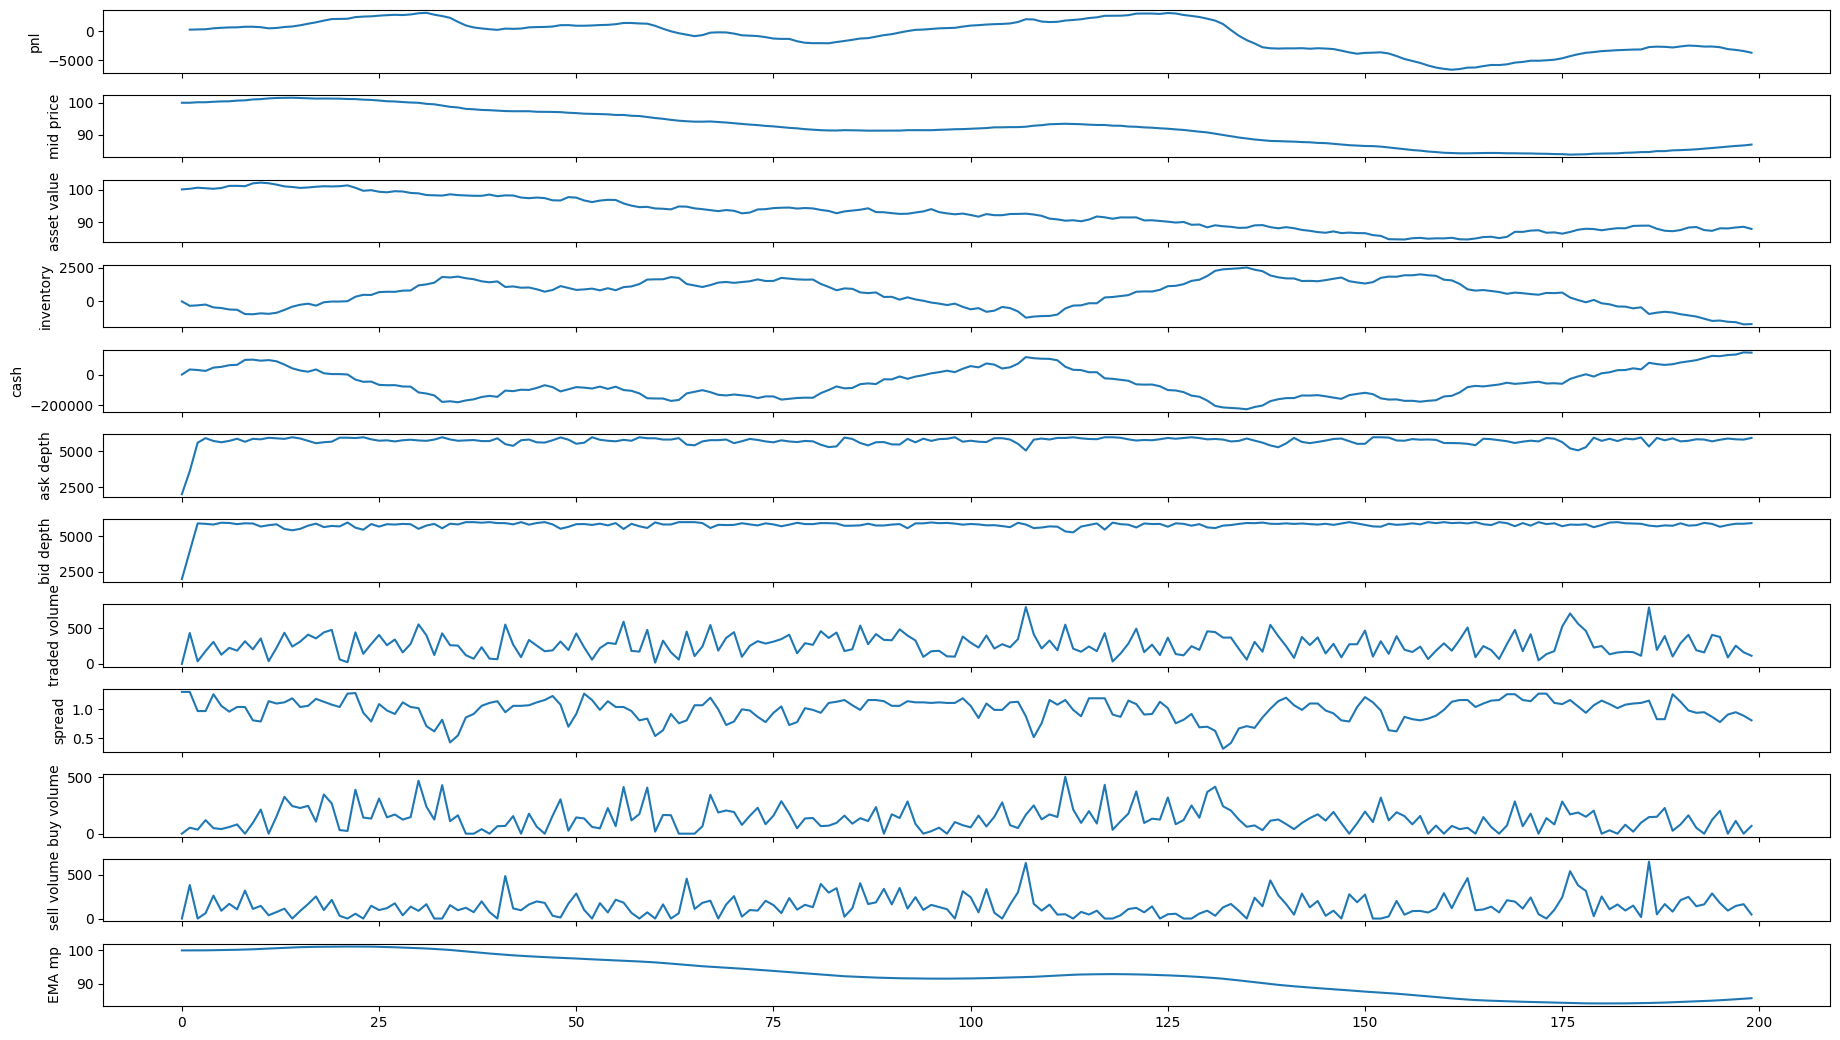

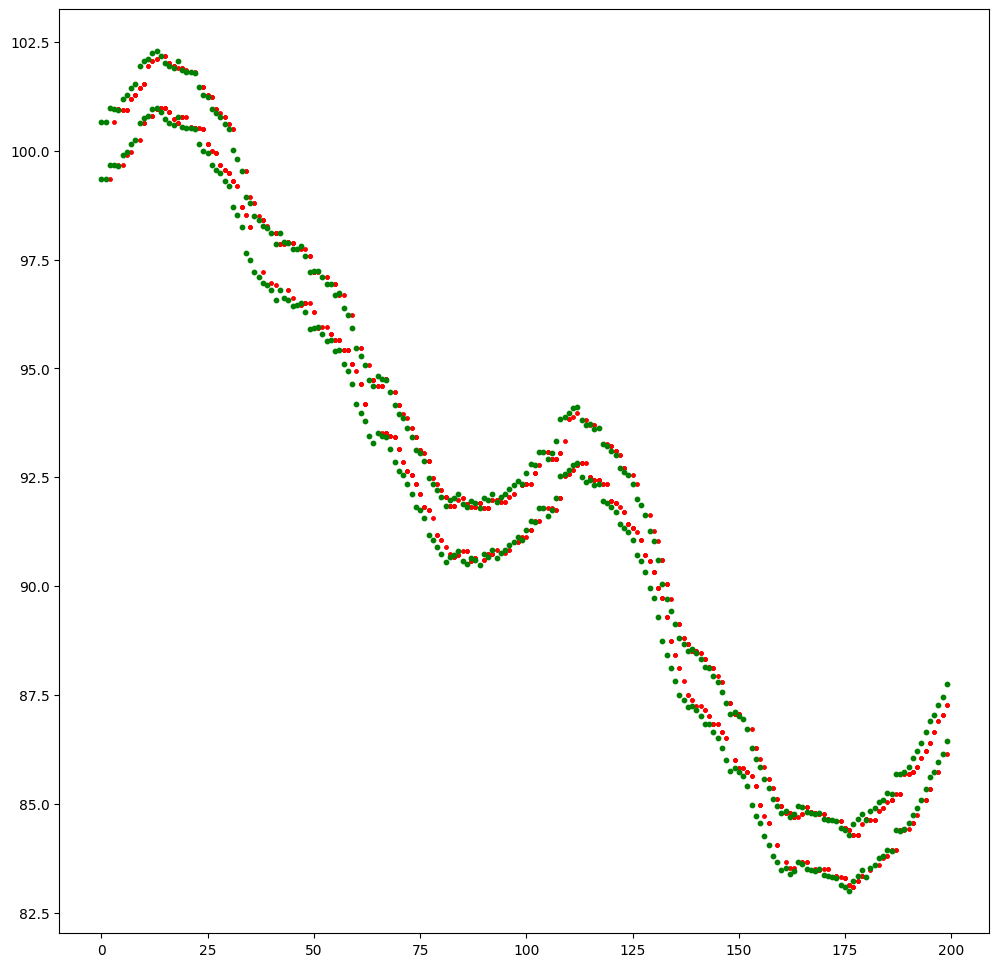

In [239]:
rng = np.random.default_rng(seed=42)
s = Asset()
ob = OrderBook()

mmStrat = SkewMarketMakingStrategy(1.3, 2000, 500000, skew_coefficient=1e-5)
mm = MarketMaker(mmStrat)
bf = BackgroundFlow(arrival_rate=5, info=0.4, ag_noise=0.6, private_info_coeff=0.8)

timesteps = 200

# Visualise orders 
mm_orders = []
noise_orders = []
trade_prices = []

def simulate(mm, bf, ob, timesteps, asset):
    trackers = {
    "pnl" : np.zeros(timesteps),
    "mid price": np.zeros(timesteps),
    "asset value": np.zeros(timesteps),
    "inventory" : np.zeros(timesteps),
    "cash" : np.zeros(timesteps),
    "ask depth": np.zeros(timesteps),
    "bid depth": np.zeros(timesteps),
    "traded volume": np.zeros(timesteps),
    "spread": np.zeros(timesteps),
    "buy volume": np.zeros(timesteps),
    "sell volume": np.zeros(timesteps),
    "EMA mp" : np.zeros(timesteps)
    }

    # cancellations are delayed. {delay: requests}
    delay = 3
    cancel_request = [[] for _ in range(delay+1)]

    for t in range(timesteps):
        # Price Moves 
        asset.evolve_value(drift=0)
        # Expiration Wheel advances
        expirations = ob.expiration_wheel.advance()
        # Expirations are processed 
        ob.process_cancellations(expirations)

        # All Actors place their orders 
        # Problem: cancellation can be shorter than shortest expiration time.
        quotes, cancellations = mm.order_update(ob)
        background_orders = bf.generate_orders(ob, asset)

        # Cancellations requested and processed
        now = t % (delay + 1)
        cancel_time = (t + delay) % (delay + 1)
        cancel_request[cancel_time] = cancellations
        ob.process_cancellations(cancel_request[now])
        cancel_request[now] = []

        # Visualise orders:
        mm_orders.append([quote.price for quote in quotes])
        noise_order_list = [order.price for order in background_orders if order.is_market == False]
        noise_orders.append(noise_order_list)

        # Orders are processed
        trades_notifs = ob.process_orders(chain(background_orders, quotes))
        trade_prices.append([notif.average_price for notif in trades_notifs.values()])

        
        # Process trade notifications for market maker 
        mm_trades_notifs = [trades_notif for _, trades_notif in trades_notifs.items() if trades_notif.trader_id == 1]
        mm.process_trades_notifications(mm_trades_notifs)

        # Calculate pnl
        pnl = mm.update_pnl()
        trackers["EMA mp"][t] = mm.EMA_mp
    

        # Track
        trackers["pnl"][t] = pnl
        trackers["mid price"][t] = ob.mid_price
        trackers["spread"][t] = ob.spread
        trackers["asset value"][t] = asset.value
        trackers["inventory"][t] = mm.inventory
        trackers["cash"][t] = mm.cash
        trackers["buy volume"][t] = mm.buy_volume
        trackers["sell volume"][t] = mm.sell_volume
        
        mm.buy_volume = 0 
        mm.sell_volume = 0

        # Track Order Book Stats
        # Very Slow Call 
        ob_stats = ob.get_stats()
        trackers["ask depth"][t] = ob_stats["Ask Depth"]
        trackers["bid depth"][t] = ob_stats["Bid Depth"]
        trackers["traded volume"][t] = ob_stats["One Tick Traded Volume"]
        
    return trackers#, ob_stats

pr = cProfile.Profile()
pr.enable()
trackers = simulate(mm, bf, ob, timesteps, s)
pr.disable()

ps = pstats.Stats(pr).sort_stats('cumtime')
ps.print_stats(20)

fig, axes = plt.subplots(len(trackers), sharex=True)
for i, (k, v) in enumerate(trackers.items()):
    axes[i].plot(v)
    axes[i].set_ylabel(k)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
fig.show()

fig2, ax2 = plt.subplots()
x = [[t]*len(orders_t) for t, orders_t in enumerate(mm_orders)]
y = mm_orders 
x_flat = [p for sublist in x for p in sublist]
y_flat = [p for sublist in y for p in sublist]

x2 = [[t]*len(orders_t) for t, orders_t in enumerate(noise_orders)]
y2 = noise_orders
x2_flat = [x for sublist in x2 for x in sublist]
y2_flat = [y for sublist in y2 for y in sublist]

x3 = [[t]*len(prices) for t, prices in enumerate(trade_prices)]
y3_flat = [y for sublist in trade_prices for y in sublist]
x3_flat = [x for sublist in x3 for x in sublist]

ax2.scatter(x3_flat, y3_flat, s=5, color='red')
ax2.scatter(x2_flat, y2_flat, s=1, color='cyan')
ax2.scatter(x_flat, y_flat, s=10, color='g')

fig2.set_size_inches(12,12)

Multi-Agent Market Maker Model! 
In order to get heterogenous competitive market makers we have the following setup: 
- market makers increase spread if their PnL is negative 
- market makers skew based on exposure

In [13]:
class MarketMakerProfile: 
    def __init__(self, risk_aversion, capital=1_000_000):
        self.risk_aversion = risk_aversion
        self.capital = capital

    def get_strategy_params(self, base_spread=0.5, base_price = 100):

        # Skew Strategy has 4 params:
        # - target spread (a more risk averse actor would decrease spread)
        # - quote size (a more risk averse actor would decrease quote size)
        # - inventory limit (a more risk averse actor would have a smaller inventory limit)
        # - skew coefficient (a more risk averse actor would have a higher skew coefficient)
        # Map risk aversion ([0, 1]) to parameters
        spread = base_spread * (1 + 2 * self.risk_aversion)

        size_pct = 0.02 * (1- 0.5 * self.risk_aversion) # up to 2% of capital per quote. 
        size = (self.capital * size_pct) / base_price

        inventory_pct = 0.8 * (1 - 0.5 * self.risk_aversion) # up to 80% of capital inventory limit
        inventory_limit = (self.capital * inventory_pct)

        skew_coefficient = 1e-5 * (1 + 5 * self.risk_aversion)

        return {
            "spread": spread,
            "size": size,
            "inventory_limit": inventory_limit,
            "skew_coefficient": skew_coefficient
        }

In [14]:
class MarketMaker():
    def __init__(self, strategy):
        self.trader_id = 1
        self.inventory = 0
        self.cash = 0
        self.strategy = strategy
        self.window_size = 20
        self.pnl_history = []
        self.inventory_history = []
    
    def order_update(self, order_book):
        # Generate an order via a strategy 
        orders = self.strategy(self, order_book)
        for order in orders:
            order.trader_id = self.trader_id
        
        cancellations = [unfilled_order[0] for unfilled_order in order_book.unfilled_orders(self.trader_id)]
        
        return orders, cancellations
    
    def process_trades_notifications(self, trades_notifications):
        for trades_notification in trades_notifications:
            if trades_notification.trader_id != self.trader_id:
                raise ValueError("Notification and trader don't match.")
            if trades_notification.is_bid:
                self.inventory += trades_notification.total_filled_volume
                self.cash -= trades_notification.total_notional
            else:
                self.inventory -= trades_notification.total_filled_volume
                self.cash += trades_notification.total_notional
        
        self.inventory_history.append(self.inventory)
        if len(self.inventory_history) > self.window_size:
            self.inventory_history.pop(0)
    
    def pnl(self, mid_price):
        # Mark to market
        unrealised_pnl = mid_price * self.inventory if mid_price else 100 * self.inventory
        total_pnl = self.cash + unrealised_pnl
        return total_pnl
    
    def update_pnl_history(self, mid_price):
        pnl = self.pnl(mid_price)
        self.pnl_history.append(pnl)

        if len(self.pnl_history) > self.window_size:
            self.pnl_history.pop(0)
    
    def recent_pnl_change(self):
        return sum(self.pnl_history[-5:-1]) / 5 - sum(self.pnl_history[0:4]) / 5
    
    def recent_fill_rate(self):
        return abs(np.sum(np.array(self.inventory_history[-5:-1]) - np.array(self.inventory_history[-6:-2])) / 5)

    def get_stats(self):
        return {
            "Inventory" : self.inventory,
            "Cash" : self.cash
        }

In [15]:
class SkewMarketMakingStrategy:
    def __init__(self, size, inventory_limit, max_skew=1, base_spread=0.1, risk_aversion=0.9):
        self.size = size
        self.base_spread = base_spread
        self.inventory_limit = inventory_limit
        self.max_skew = max_skew
        self.spread = base_spread

        # Risk aversion based instance variables 

        # Target pnl:
        # Risk-Netural: $ 0.25 / tick 
        # Risk-Averse: $ 1 / tick 
        self.target_pnl = 5 * (1 + 3 * risk_aversion)

        # Adjustment speed: 
        # Risk-Netural: 5% per tick 
        # Risk-Averse: 1 % per tick
        self.adjustment_speed = 0.03 * (1 - 0.8 * risk_aversion)

        # Fill rate targets
        self.target_fill_rate = 0.1 * (1 - 0.5 * risk_aversion)

        # Bounds: 
        self.min_spread = 0.05 
        self.max_spread = 3
        self.min_fill_rate = 0.02
    
    def adjust_spread(self, market_maker):
        
        if len(market_maker.pnl_history) < 20: 
            print("history_not long enough yet")
            return
        
        # PnL consideration
        pnl_change = market_maker.recent_pnl_change()
        # Distance to target
        to_pnl_target = pnl_change - self.target_pnl
        
        # Fill rate consideration
        fill_rate = market_maker.recent_fill_rate()
        print("fill_rate: ", fill_rate)
        to_fill_target = fill_rate - self.target_fill_rate

        if fill_rate < self.min_fill_rate:
            self.spread *= (1 - self.adjustment_speed)
        elif to_pnl_target > 0: 
            # PnL is larger than target so we can narrow spreads 
            self.spread *= (1 - self.adjustment_speed)
            if self.spread < self.min_spread:
                self.spread = self.min_spread
            print(f"good PnL, spread: {self.spread}")
        elif to_pnl_target < 0:
            if self.spread > 0.1:
                self.spread *= (1 + 2 * self.adjustment_speed)
            else: 
                # If spread is very small we need a quick shock
                self.spread += self.adjustment_speed
            if self.spread > self.max_spread:
                self.spread = self.max_spread

            print(f"bad PnL, spread: {self.spread}")


    def __call__(self, market_maker, order_book):

        if order_book.mid_price:
            mid_price = order_book.mid_price
        else: 
            print("no mid_price for some reason")
            # Hard code mid_price (maybe change)
            mid_price = 100

        # Update the pnl history
        market_maker.update_pnl_history(mid_price)

        # Adjust spread
        self.adjust_spread(market_maker)

        orders = [] 
        exposure = market_maker.inventory * mid_price

        # Close to maximum skew if abs(exposure) is more than inventory_limit
        skew = np.tanh(3 * exposure / self.inventory_limit) * self.max_skew
        print("skew: ", skew)
  
        if exposure <= self.inventory_limit:
            price = mid_price - self.spread / 2 - skew
            orders.append(Order(price, self.size, True, False))
        if exposure >= -self.inventory_limit:
            price = mid_price + self.spread / 2 - skew
            orders.append(Order(price, self.size, False, False))

        return orders

In [113]:
rng = np.random.default_rng(seed=42)
s = Asset()
ob = OrderBook()

mmStrat = SkewMarketMakingStrategy(10_000, 5_000_000, base_spread = 0.2, risk_aversion=0.1)
mm = MarketMaker(mmStrat)
bf = BackgroundFlow(arrival_rate = 12, info=0.2, ag_noise=0.1, private_info_coeff=0.9)

timesteps = 2000

# Visualise orders 
mm_orders = []
noise_orders = []
trade_prices = []

def simulate(mm, bf, ob, timesteps, asset):
    trackers = {
    "pnl" : np.zeros(timesteps),
    "mid price": np.zeros(timesteps),
    "asset value": np.zeros(timesteps),
    "inventory" : np.zeros(timesteps),
    "cash" : np.zeros(timesteps),
    "ask depth": np.zeros(timesteps),
    "bid depth": np.zeros(timesteps),
    "traded volume": np.zeros(timesteps),
    "spread": np.zeros(timesteps),
    }

    # cancellations are delayed. {delay: requests}
    delay = 2
    cancel_request = [[] for _ in range(delay+1)]

    for t in range(timesteps):
        # Price Moves 
        asset.evolve_value(drift=0, sigma=0.1)
        # Expiration Wheel advances
        expirations = ob.expiration_wheel.advance()
        # Expirations are processed 
        ob.process_cancellations(expirations)

        # All Actors place their orders 
        # Problem: cancellation can be shorter than shortest expiration time.
        quotes, cancellations = mm.order_update(ob)
        background_orders = bf.generate_orders(ob, asset)

        # Cancellations requested and processed
        now = t % (delay + 1)
        cancel_time = (t + delay) % (delay + 1)
        cancel_request[cancel_time] = cancellations
        ob.process_cancellations(cancel_request[now])
        cancel_request[now] = []

        # Visualise orders:
        mm_orders.append([quote.price for quote in quotes])
        noise_order_list = [order.price for order in background_orders if order.is_market == False]
        noise_orders.append(noise_order_list)
        # Track Order Book Stats
        # Very Slow Call 
        ob_stats = ob.get_stats()
        trackers["ask depth"][t] = ob_stats["Ask Depth"]
        trackers["bid depth"][t] = ob_stats["Bid Depth"]
        trackers["traded volume"][t] = ob_stats["One Tick Traded Volume"]

        # Orders are processed
        trades_notifs = ob.process_orders(chain(background_orders, quotes))
        trade_prices.append([notif.average_price for notif in trades_notifs.values()])

        
        # Process trade notifications for market maker 
        mm_trades_notifs = [trades_notif for _, trades_notif in trades_notifs.items() if trades_notif.trader_id == 1]
        mm.process_trades_notifications(mm_trades_notifs)

        # Calculate pnl
        pnl = mm.pnl_history[-1] if mm.pnl_history else 0

        # Track
        trackers["pnl"][t] = pnl
        trackers["mid price"][t] = ob.mid_price
        trackers["spread"][t] = ob.spread
        trackers["asset value"][t] = asset.value
        trackers["inventory"][t] = mm.inventory
        trackers["cash"][t] = mm.cash
        
    return trackers#, ob_stats

pr = cProfile.Profile()
pr.enable()
trackers = simulate(mm, bf, ob, timesteps, s)
pr.disable()

ps = pstats.Stats(pr).sort_stats('cumtime')
ps.print_stats(20)

fig, axes = plt.subplots(len(trackers), sharex=True)
for i, (k, v) in enumerate(trackers.items()):
    axes[i].plot(v)
    axes[i].set_ylabel(k)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
fig.show()

fig2, ax2 = plt.subplots()
x = [[t]*len(orders_t) for t, orders_t in enumerate(mm_orders)]
y = mm_orders 
x_flat = [p for sublist in x for p in sublist]
y_flat = [p for sublist in y for p in sublist]

x2 = [[t]*len(orders_t) for t, orders_t in enumerate(noise_orders)]
y2 = noise_orders
x2_flat = [x for sublist in x2 for x in sublist]
y2_flat = [y for sublist in y2 for y in sublist]

x3 = [[t]*len(prices) for t, prices in enumerate(trade_prices)]
y3_flat = [y for sublist in trade_prices for y in sublist]
x3_flat = [x for sublist in x3 for x in sublist]

ax2.scatter(x3_flat, y3_flat, s=5, color='red')
ax2.scatter(x2_flat, y2_flat, s=1, color='cyan')
ax2.scatter(x_flat, y_flat, s=10, color='g')

fig2.set_size_inches(12,12)

TypeError: MarketMaker.order_update() missing 1 required positional argument: 't'

In [ ]:
# In order to prevent oscillations we need Market Maker heterogeneity. We introduce update frequency heterogeneity first. Slower market makers react more slowly to price signals and post bigger quotes that stick around longer.

class MarketMaker():
    def __init__(self, strategy, speed='slow'):
        speeds = {
            'slow': 50,
            'mid': 10,
            'fast': 1
        }

        self.trader_id = 1
        self.inventory = 0
        self.cash = 0
        self.strategy = strategy

        self.cost_horizon = speeds[speed]
        self.window_size = speeds[speed]
        self.quote_frequency = speeds[speed]

        self.pnl_history = []
        self.price_history = []
        self.inventory_history = []
        self.signed_volume_history = []
        self.spread_captured_history = []

    def order_update(self, order_book, t):
        # Called Every Tick.
        if order_book.mid_price:
            mid_price = order_book.mid_price
        elif t == 0:
            mid_price = 100
        else:
            # print()
            # print("Order book may have dried up?")
            # print(f"time: {t}")
            # stats = order_book.get_stats()
            # print(f"bid depth: {stats['Bid Depth']}")
            # print(f"ask depth: {stats['Ask Depth']}")
            # We set mid-price to last known mid-price
            i = -1
            while self.price_history[i] is None:
                i -= 1 
            mid_price = self.price_history[i]
            # Hard Code Mid-Price    
        
        # Update the pnl history (every tick)
        self.update_history(mid_price)

        # Generate an order via a strategy at required frequency
        orders = []
        cancellations = []

        if t % self.quote_frequency == 0:
            orders = self.strategy(self, mid_price)
            for order in orders:
                order.trader_id = self.trader_id
                # We need to make sure liquidity stays until next update
                order.lifetime = self.quote_frequency
        
            cancellations = [unfilled_order[0] for unfilled_order in order_book.unfilled_orders(self.trader_id)]
        
        return orders, cancellations
    
    def process_trades_notifications(self, trades_notifications):
        buy_volume = 0
        sell_volume = 0
        for trades_notification in trades_notifications:
            if trades_notification.trader_id != self.trader_id:
                raise ValueError("Notification and trader don't match.")
            if trades_notification.is_bid:
                self.inventory += trades_notification.total_filled_volume
                self.cash -= trades_notification.total_notional

                buy_volume = trades_notification.total_filled_volume 
            else:
                self.inventory -= trades_notification.total_filled_volume
                self.cash += trades_notification.total_notional

                sell_volume += trades_notification.total_filled_volume 
        
        self.signed_volume_history.append(buy_volume - sell_volume)
        # Lower bound for spread
        self.spread_captured_history.append(min(buy_volume, sell_volume) * self.strategy.spread)
        
        self.inventory_history.append(self.inventory)
        if len(self.inventory_history) > 2 * self.window_size:
            self.inventory_history.pop(0)
    
    def pnl(self, mid_price):
        # Mark to market
        unrealised_pnl = mid_price * self.inventory if mid_price else 100 * self.inventory
        total_pnl = self.cash + unrealised_pnl
        return total_pnl
    
    def update_history(self, mid_price):
        pnl = self.pnl(mid_price)
        self.pnl_history.append(pnl)
        self.price_history.append(mid_price)

        if len(self.pnl_history) > 2 * self.window_size:
            self.pnl_history.pop(0)
        if len(self.price_history) > 2 * self.window_size:
            self.price_history.pop(0)
    
    def costs(self, averaging_window=5):

        min_len = self.cost_horizon + averaging_window

        if min(len(self.inventory_history), len(self.signed_volume_history), len(self.price_history)) < min_len:
            return {
                "adverse selection" : 0,
                "inventory": 0
            }
        
        else:
            ad_select_cost = 0 
            inventory_cost = 0 

            for i in range(averaging_window):
                sgn_volume = self.signed_volume_history[-self.cost_horizon - i]
                inventory = self.inventory_history[-self.cost_horizon - i]
                price_change_pt = self.price_history[-1 - i] - self.price_history[- self.cost_horizon - i] / self.cost_horizon
                ad_select_cost += - sgn_volume * price_change_pt
                inventory_cost += inventory * price_change_pt
        
        ad_select_cost /= averaging_window
        inventory_cost /= averaging_window

        return {
            "adverse selection" : ad_select_cost,
            "inventory": inventory_cost
        }
    
    def pnl_pt(self, averaging_window=5):
        min_length = self.window_size + averaging_window
        if len(self.pnl_history) < min_length:
            return 0 
        else:
            pnl = 0
            for i in range(averaging_window):
                pnl += ( self.pnl_history[-1-i] - self.pnl_history[- self.window_size - i] ) / self.window_size
        
        pnl /= averaging_window
        return pnl
    
    def fill_pt(self, averaging_window=5):
        min_length = self.window_size + averaging_window
        if len(self.pnl_history) < min_length:
            return 0 
        else:
            fill_rate = 0 
            for i in range(averaging_window):
                fill_rate += abs(self.inventory_history[-1 - i] - self.inventory_history[- self.window_size - i]) / self.strategy.size
            
        fill_rate /= averaging_window
        return fill_rate
    
    def max_drawdown(self):
        recent_pnl = self.pnl_history[-self.window_size:]
        return min(0, np.min(recent_pnl) - recent_pnl[0])

    def get_stats(self):
        return {
            "Inventory" : self.inventory,
            "Cash" : self.cash
        }
    
class SkewMarketMakingStrategy:
    def __init__(self, size, inventory_limit, max_skew=5, base_spread=0.1, risk_aversion=0.9):
        self.size = size
        self.base_spread = base_spread
        self.inventory_limit = inventory_limit
        self.max_skew = max_skew
        self.spread = base_spread
        ## Tracking
        self.skew = 0
        self.bid_price = 0 
        self.ask_price = 0
        self.calc_mid_price = np.zeros(2)

        # Risk aversion based instance variables

        # Target pnl:
        # Risk-Netural: $ 0.25 / tick 
        # Risk-Averse: $ 1 / tick 
        self.target_pnl = 0.25 * (1 + 3 * risk_aversion)
        self.risk_aversion = risk_aversion
        self.adjustment_speed = 0.05

        # Bounds: 
        self.min_spread = 0.05 
        self.max_spread = 3
        self.min_fill_rate = 0.02
        self.drawdown_coeff = 10 * self.target_pnl 
    
    def adjust_spread(self, market_maker):
        
        if len(market_maker.pnl_history) < market_maker.window_size + 2: 
            return
        
        # If out of the game we should get back in the game
        fill_rate = market_maker.recent_fill_rate()
        if fill_rate < self.min_fill_rate:
            self.spread *= (1 - self.adjustment_speed)
            return
        
        # If drawdown is to great IMMEDIATELY increase spread with an additive shock scaled by risk_aversion and drawdown_severity
        drawdown = market_maker.max_drawdown()
        threshold = self.drawdown_coeff * market_maker.window_size
        if abs(drawdown) > threshold:
            print(f"drawdown shock {drawdown}")
            drawdown_severity = abs(drawdown) / threshold
            shock = self.spread * drawdown_severity * (1 + 2 * self.risk_aversion)
            self.spread += shock
            print(f"increased spread by: {shock}")
            self.spread = min(self.spread, self.max_spread)
            return 

        # Bad PnL => increase spread
        pnl_change = market_maker.recent_pnl_change()
        to_pnl_target = pnl_change - self.target_pnl

        if to_pnl_target > 0: 
            # PnL is larger than target so we can narrow spreads 
            self.spread *= (1 - self.adjustment_speed) ** market_maker.quote_frequency
            self.spread = max(self.spread, self.min_spread)
        elif to_pnl_target < 0:
            if self.spread > 0.1:
                self.spread *= (1 + self.adjustment_speed) ** market_maker.quote_frequency
            else: 
                # If spread is very small we need a quick shock
                self.spread += self.adjustment_speed
            self.spread = min(self.spread, self.max_spread)


    def __call__(self, market_maker, mid_price):

        # In order to be competitive the strategy must:
        # 1) React to bad PnL 
        # 2) Compete to be filled

        # 1) In order to react we must diagnose why the PnL is bad: 
        # Either:
        #   i) We are carrying inventory risk and the market is moving against us
        #   ii) Adverse selection risk is creating losses on every trade 
        # if i) We need to skew aggressively to offload inventory.
        # if ii) We increase spread. 

        # 2) In order to compete to be filled we need to tighten spread. This is the primary risk-reward balance with (ii).

        # We need to prioritise 1) and then we can deal with 2) once PnL is improving. 

        pnl_pt = market_maker.pnl_pt()

        if pnl_rate < 0:
            # We are in 1) and need to diagnose 
            costs = market_maker.costs()
            inventory_cost = costs["inventory"]
            selection_cost = costs["adverse selection"]
            if inventory_cost > 0.5
            # To DO: Rolling Average Captured spread. + strategy. 




        # Adjust spread
        self.adjust_spread(market_maker)

        orders = [] 
        exposure = market_maker.inventory * mid_price

        # Close to maximum skew if abs(exposure) is more than inventory_limit
        skew = np.tanh(3 * exposure / self.inventory_limit) * self.max_skew
        ##
        self.skew = skew
        self.calc_mid_price[0] = self.calc_mid_price[1]
        self.calc_mid_price[1] = mid_price

        # We have pricing tiers in order to decrease adverse selection risk: 
        # Depending on risk coefficient and capital size the fraction may differ
        size_tier = [0.2, 0.3, 0.5]
        spread_tier = [0.5, 0.8, 1]

        if exposure <= self.inventory_limit:
            for i in range(len(size_tier)):
                price = mid_price - spread_tier[i] * self.spread - skew
                volume = self.size * size_tier[i]
                orders.append(Order(price, volume, True, False))
            ##
            self.bid_price = price
        if exposure >= -self.inventory_limit:
            for i in range(len(size_tier)):
                price = mid_price + spread_tier[i] * self.spread - skew
                volume = self.size * size_tier[i]
                orders.append(Order(price, volume, False, False))
            ##
            self.ask_price = price
        

        return orders



SyntaxError: expected ':' (1053980640.py, line 252)

drawdown shock -204.29304246680113
increased spread by: 0.30172510887404475

Order book may have dried up?
time: 550
bid depth: 87
ask depth: 0
drawdown shock -2293.2650513872795
increased spread by: 43.55862919605788
drawdown shock -484.20369393599685
increased spread by: 10.19062543545298
drawdown shock -2466.9280975965667
increased spread by: 40.42217408606484
drawdown shock -330.9899999999907
increased spread by: 6.966066461538265
drawdown shock -462.0699999999779
increased spread by: 10.236627692307204
drawdown shock -2329.307588913711
increased spread by: 49.02296587129163
drawdown shock -3525.9946201122075
increased spread by: 78.11434235325505
drawdown shock -293.3440301633964
increased spread by: 0.3249349257194545
drawdown shock -368.48926209431374
increased spread by: 1.2923698731410178
drawdown shock -208.7362885729235
increased spread by: 2.724189374704631


/var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/410626566.py:127: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


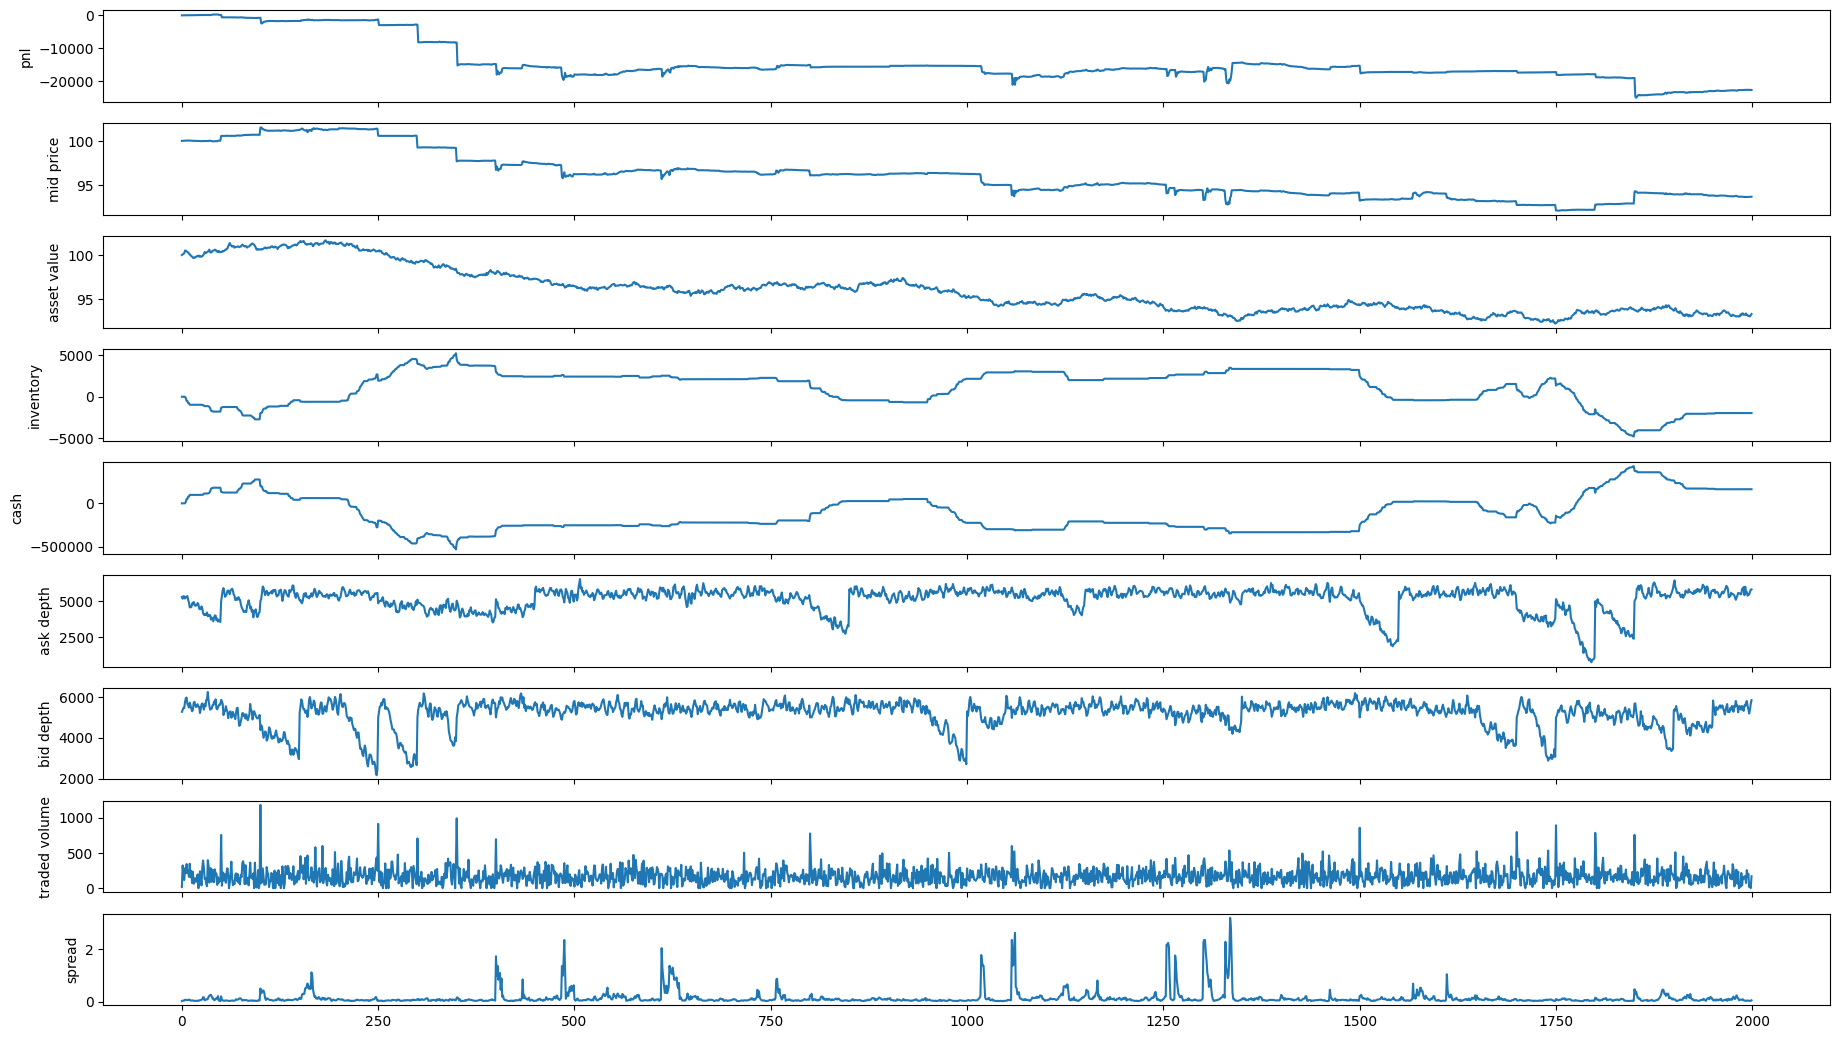

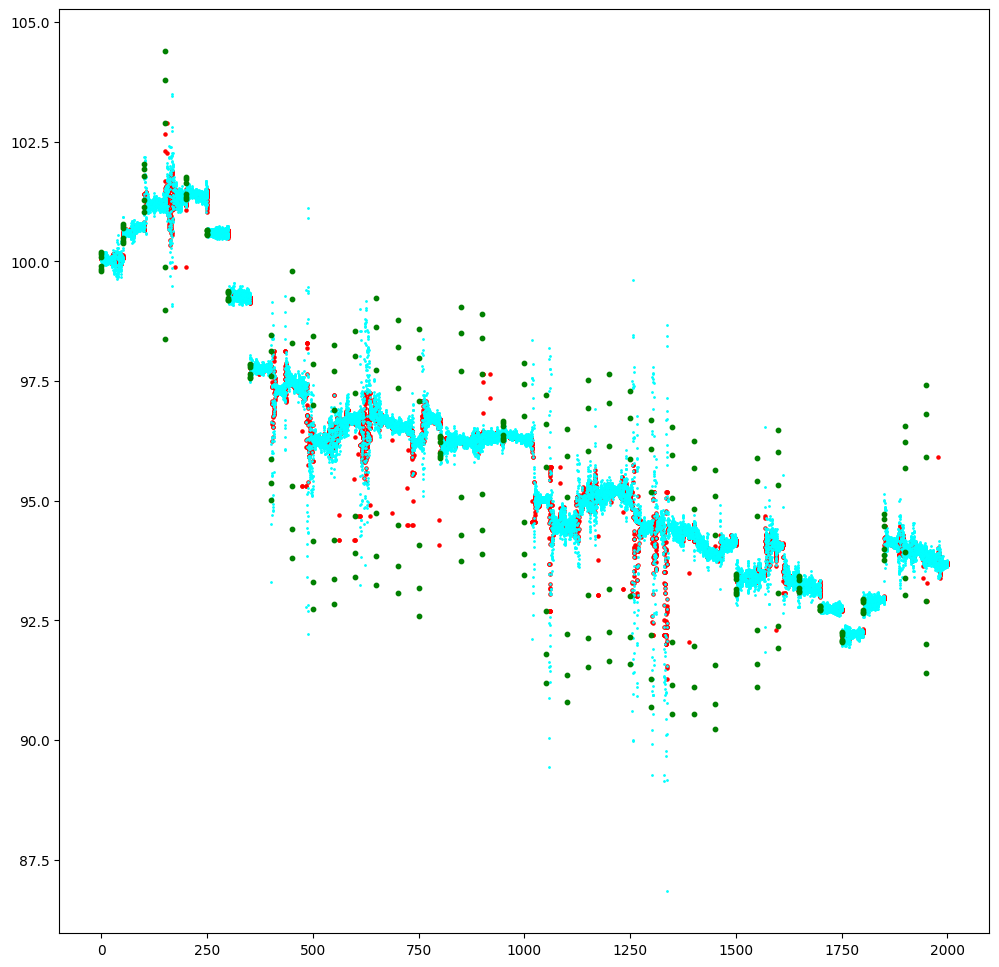

In [189]:
rng = np.random.default_rng(seed=42)
s = Asset()
ob = OrderBook()

mmStrat = SkewMarketMakingStrategy(5_000, 5_000_000, base_spread = 0.2, risk_aversion=0.1)
mm = MarketMaker(mmStrat, speed='slow')
bf = BackgroundFlow(arrival_rate = 12, info=0.15, ag_noise=0.1, private_info_coeff=0.9)

timesteps = 2000

# Visualise orders 
mm_orders = []
noise_orders = []
max_noise = []
min_noise = []
trade_prices = []

def simulate(mm, bf, ob, timesteps, asset):
    price_jumps = 0 
    trackers = {
    "pnl" : np.zeros(timesteps),
    "mid price": np.zeros(timesteps),
    "asset value": np.zeros(timesteps),
    "inventory" : np.zeros(timesteps),
    "cash" : np.zeros(timesteps),
    "ask depth": np.zeros(timesteps),
    "bid depth": np.zeros(timesteps),
    "traded volume": np.zeros(timesteps),
    "spread": np.zeros(timesteps),
    }

    # cancellations are delayed. {delay: requests}
    delay = 2
    cancel_request = [[] for _ in range(delay+1)]

    for t in range(timesteps):
        # Price Moves 
        asset.evolve_value(drift=0, sigma=0.1)
        # Expiration Wheel advances
        expirations = ob.expiration_wheel.advance()
        # Expirations are processed 
        ob.process_cancellations(expirations)

        # All Actors place their orders 
        # Problem: cancellation can be shorter than shortest expiration time.
        quotes, cancellations = mm.order_update(ob, t)
        background_orders = bf.generate_orders(ob, asset)

        # Cancellations requested and processed
        now = t % (delay + 1)
        cancel_time = (t + delay) % (delay + 1)
        cancel_request[cancel_time] = cancellations
        ob.process_cancellations(cancel_request[now])
        cancel_request[now] = []

        # Visualise orders:
        mm_orders.append([quote.price for quote in quotes])
        noise_order_list = [order.price for order in background_orders if order.is_market == False]
        noise_orders.append(noise_order_list)
        if noise_order_list:
            max_noise.append(np.max(noise_order_list))
            min_noise.append(np.min(noise_order_list))

        # Orders are processed
        trades_notifs = ob.process_orders(chain(background_orders, quotes))
        trade_prices.append([notif.average_price for notif in trades_notifs.values()])

        # Track Order Book Stats
        # Very Slow Call 
        ob_stats = ob.get_stats()
        trackers["ask depth"][t] = ob_stats["Ask Depth"]
        trackers["bid depth"][t] = ob_stats["Bid Depth"]
        trackers["traded volume"][t] = ob_stats["One Tick Traded Volume"]

        
        # Process trade notifications for market maker 
        mm_trades_notifs = [trades_notif for _, trades_notif in trades_notifs.items() if trades_notif.trader_id == 1]
        mm.process_trades_notifications(mm_trades_notifs)

        # Calculate pnl
        pnl = mm.pnl_history[-1] if mm.pnl_history else 0

        # Track
        trackers["pnl"][t] = pnl
        trackers["mid price"][t] = ob.mid_price
        trackers["spread"][t] = ob.spread
        trackers["asset value"][t] = asset.value
        trackers["inventory"][t] = mm.inventory
        trackers["cash"][t] = mm.cash

        # if t > 1:
        #     barrier = "========================"
        #     cmp = ob.mid_price if ob.mid_price else asset.value
        #     pmp = trackers["mid price"][t-1]
        #     if abs(cmp - pmp) > 0.01 * mm.quote_frequency:
        #         price_jumps += 1
        #         print(barrier)
        #         print(f"PRICE JUMP: {price_jumps} @ time: {t}")
        #         print(f"Mid Price : {cmp}, Previous Mid Price: {pmp}")
        #         print(f"ASK DEPTH: {ob_stats['Ask Depth']}, BID DEPTH: {ob_stats['Bid Depth']}")
        #         print(f"MARKET MAKER PARAMETERS")
        #         print(f"Skew: {mm.strategy.skew}")
        #         print(f"Bid Price: {mm.strategy.bid_price}")
        #         print(f"Ask Price: {mm.strategy.ask_price}")
        #         print(f"Pre-Quote mid-price: {mm.strategy.calc_mid_price[1]}")
        #         print(f"Previous Pre-Quote mid-price: {mm.strategy.calc_mid_price[0]}")
        #         print(barrier)
                

        
    return trackers#, ob_stats

#pr = cProfile.Profile()
#pr.enable()
trackers = simulate(mm, bf, ob, timesteps, s)
#pr.disable()

#ps = pstats.Stats(pr).sort_stats('cumtime')
#ps.print_stats(20)

fig, axes = plt.subplots(len(trackers), sharex=True)
for i, (k, v) in enumerate(trackers.items()):
    axes[i].plot(v)
    axes[i].set_ylabel(k)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
fig.show()

fig2, ax2 = plt.subplots()
x = [[t]*len(orders_t) for t, orders_t in enumerate(mm_orders)]
y = mm_orders 
x_flat = [p for sublist in x for p in sublist]
y_flat = [p for sublist in y for p in sublist]

x2 = [[t]*len(orders_t) for t, orders_t in enumerate(noise_orders)]
y2 = noise_orders
x2_flat = [x for sublist in x2 for x in sublist]
y2_flat = [y for sublist in y2 for y in sublist]

x3 = [[t]*len(prices) for t, prices in enumerate(trade_prices)]
y3_flat = [y for sublist in trade_prices for y in sublist]
x3_flat = [x for sublist in x3 for x in sublist]

ax2.scatter(x3_flat, y3_flat, s=5, color='red')
ax2.scatter(x2_flat, y2_flat, s=1, color='cyan')
ax2.scatter(x_flat, y_flat, s=10, color='g')

t = [i for i in range(timesteps)]
#ax2.scatter(t, max_noise, s=1, color='orange')
#ax2.scatter(t, min_noise, s=1, color='orange')

fig2.set_size_inches(12,12)

In [33]:
n_market_makers = 10
market_makers = []
for i in range(1,n_market_makers+1):
    risk_aversion = rng.random()
    size = rng.integers(100, 1000)
    inventory_limit = rng.integers(10 * size, 100 * size)
    skew_strat = SkewMarketMakingStrategy(size, inventory_limit, risk_aversion=risk_aversion, max_skew=1)
    mm = MarketMaker(skew_strat)
    mm.trader_id = i
    market_makers.append(mm)

# some rough math: average capital ~ 2^19 ~ $500,000 
# average quote size: 1.5% capital / average asset price ~ 75
# average depth: 10 * 75 = 750 

# background orders — average size 55
# random limit orders ~ 50% of background flow
# market orders weighted fraction of orders: 55 * lambda * 0.5; lambda is the arrival rate.
# If we aim for around 30% market orders: lambda ~ 37 

no mid_price for some reason
fill_rate:  0.0
skew:  -0.5389580239804407
no mid_price for some reason
fill_rate:  0.0
skew:  -0.734453202786316
no mid_price for some reason
fill_rate:  0.0
skew:  0.9990746672319601
no mid_price for some reason
fill_rate:  0.0
skew:  0.9988595163953703
no mid_price for some reason
fill_rate:  0.0
skew:  0.8794295369939207
no mid_price for some reason
fill_rate:  0.0
skew:  -0.9999999946801128
no mid_price for some reason
fill_rate:  57.4
bad PnL, spread: 1.7637291372958077
skew:  0.9999999999998552
no mid_price for some reason
fill_rate:  0.0
skew:  -0.796621978382781
no mid_price for some reason
fill_rate:  223.6
bad PnL, spread: 0.4475487661747507
skew:  -0.8993667514795611
no mid_price for some reason
fill_rate:  115.4
bad PnL, spread: 1.8867254812395071
skew:  0.9999916469697498
fill_rate:  0.0
skew:  0.6747838165837204
fill_rate:  0.0
skew:  0.9978943689179904
fill_rate:  0.0
skew:  -0.9999939257696194
fill_rate:  0.0
skew:  -0.9991748870063555
fill

/var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_67242/61564467.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


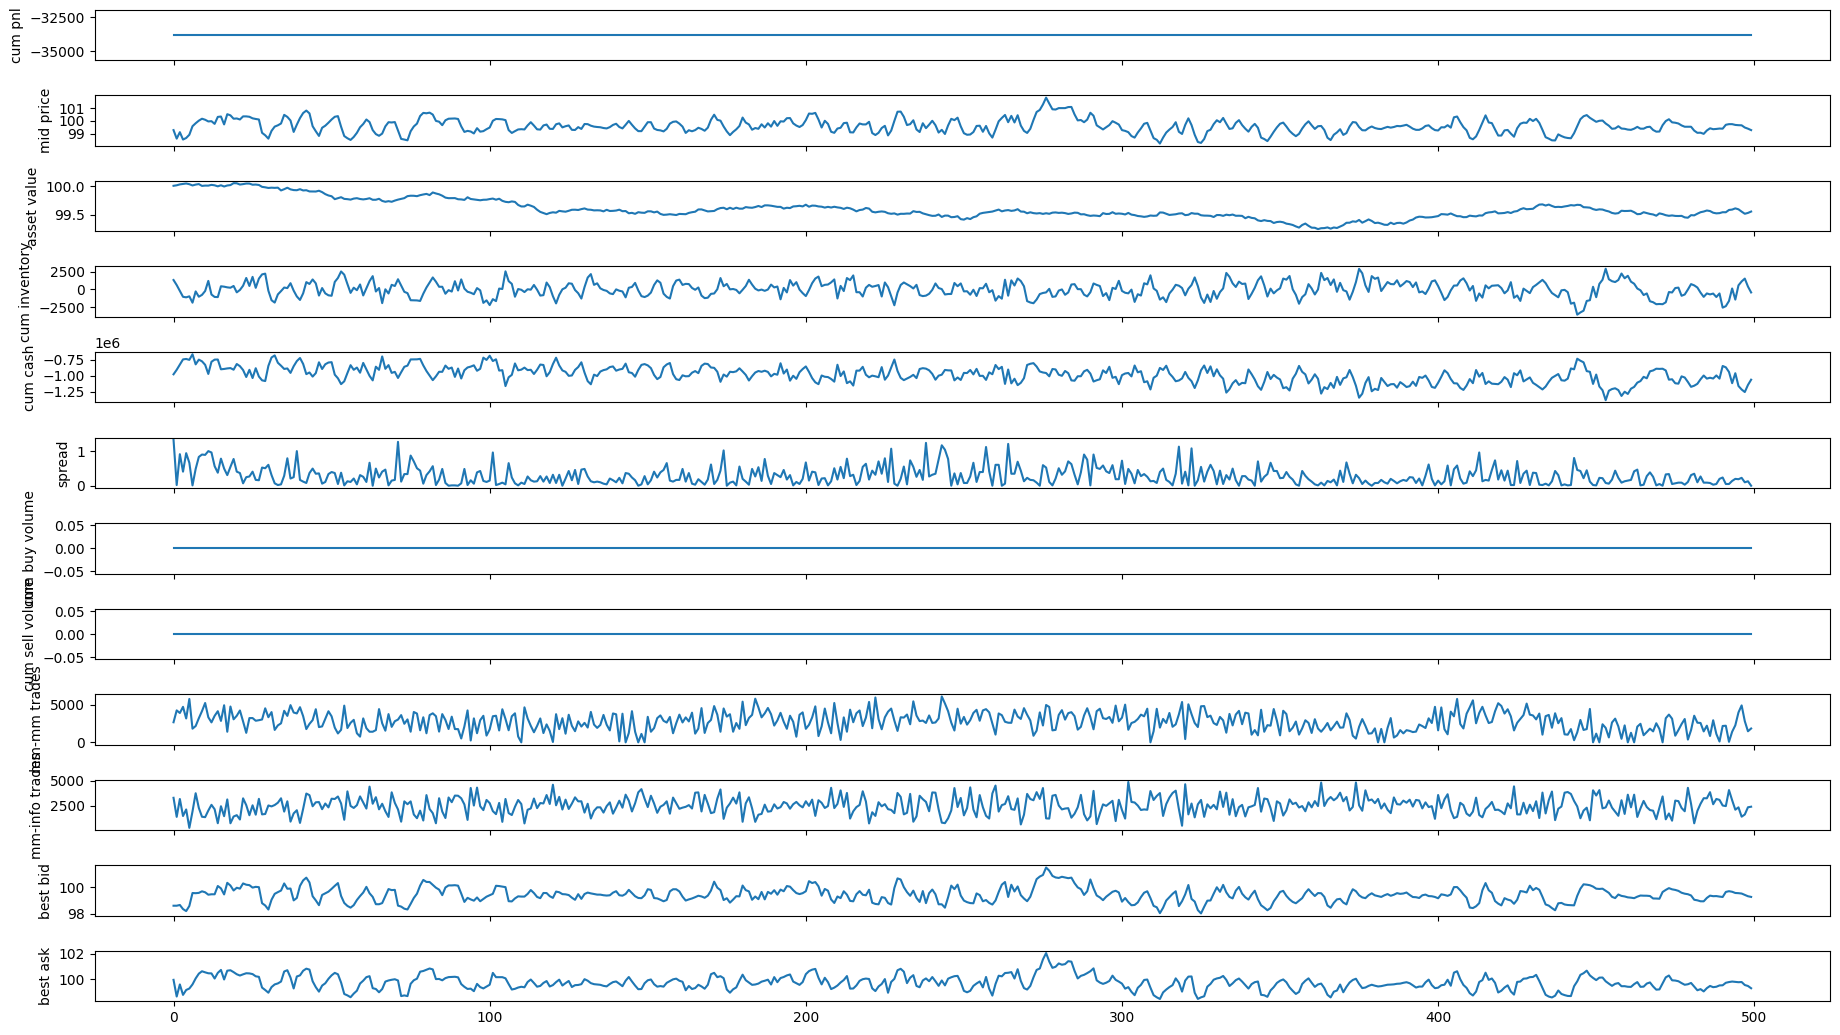

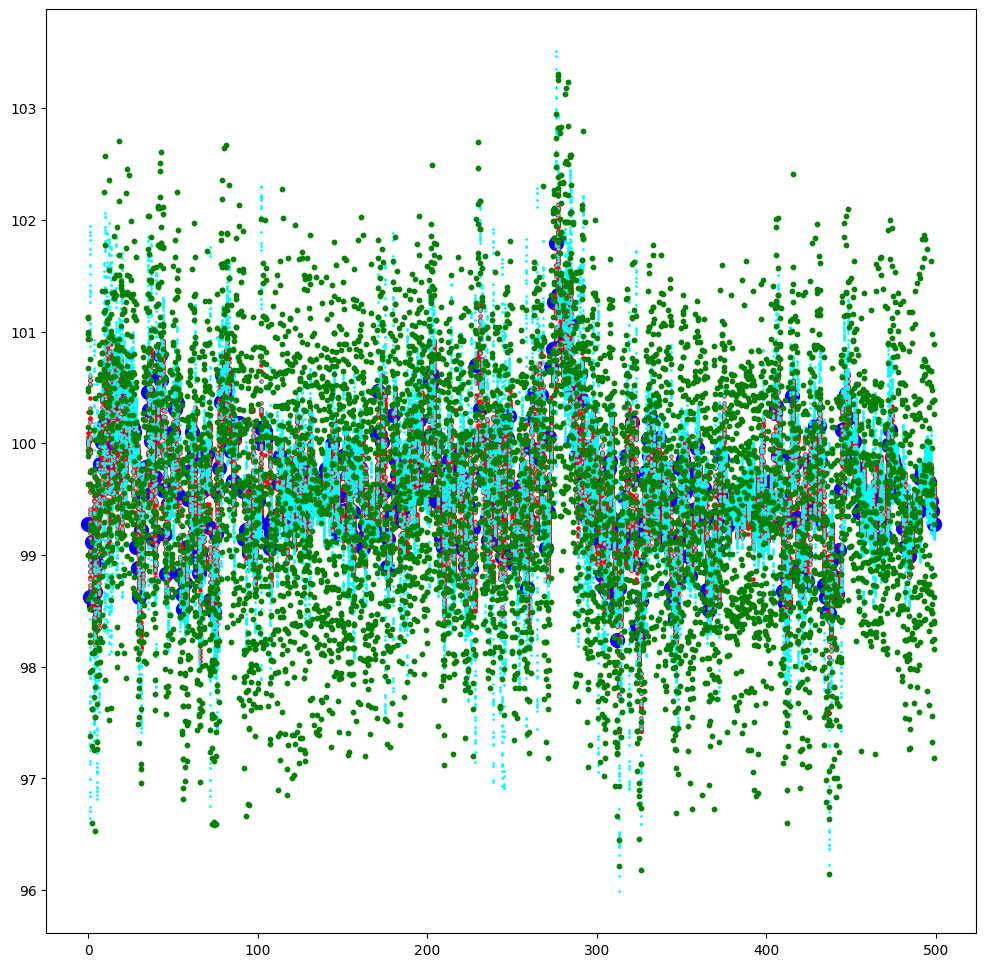

In [93]:
rng = np.random.default_rng(seed=42)
s = Asset()
ob = OrderBook()

bf = BackgroundFlow(arrival_rate = 100, info=0.15, ag_noise=0.1, private_info_coeff=1)
timesteps = 500

# Visualise orders 
mm_orders = []
noise_orders = []
trade_prices = []

def simulate(mm, bf, ob, timesteps, asset):
    trackers = {
    "cum pnl" : np.zeros(timesteps),
    "mid price": np.zeros(timesteps),
    "asset value": np.zeros(timesteps),
    "cum inventory" : np.zeros(timesteps),
    "cum cash" : np.zeros(timesteps),
    "spread": np.zeros(timesteps),
    "cum buy volume": np.zeros(timesteps),
    "cum sell volume": np.zeros(timesteps),
    "mm-mm trades": np.zeros(timesteps),
    "mm-info trades": np.zeros(timesteps),
    "best bid": np.zeros(timesteps),
    "best ask": np.zeros(timesteps)
    }

    # cancellations are delayed. {delay: requests}
    delay = 3
    cancel_request = [[] for _ in range(delay+1)]

    for t in range(timesteps):
        # Price Moves 
        asset.evolve_value(drift=0, sigma=0.02)
        # Expiration Wheel advances
        expirations = ob.expiration_wheel.advance()
        # Expirations are processed 
        ob.process_cancellations(expirations)

        # All Actors place their orders 
        # Problem: cancellation can be shorter than shortest expiration time.
        mm_quotes = []
        mm_cancellations = []
        for market_maker in market_makers:
            quotes, cancellations = market_maker.order_update(ob)
            mm_quotes.extend(quotes)
            mm_cancellations.extend(cancellations)
        background_orders = bf.generate_orders(ob, asset)

        # Cancellations requested and processed
        now = t % (delay + 1)
        cancel_time = (t + delay) % (delay + 1)
        cancel_request[cancel_time] = mm_cancellations
        ob.process_cancellations(cancel_request[now])
        cancel_request[now] = []

        # Visualise orders:
        mm_orders.append([quote.price for quote in mm_quotes])
        noise_order_list = [order.price for order in background_orders if order.is_market == False]
        noise_orders.append(noise_order_list)

        # Orders are processed
        trades_notifs = ob.process_orders(chain(background_orders, mm_quotes))
        trade_prices.append([notif.average_price for notif in trades_notifs.values()])

        
        # Process trade notifications for market maker 
        cum_pnl = 0 
        cum_inventory = 0
        cum_cash = 0
        mm_mm_trade_volume = 0 
        mm_info_trade_volume = 0
        for market_maker in market_makers:
            mm_trades_notifs = [trades_notif for _ , trades_notif in trades_notifs.items() if trades_notif.trader_id == market_maker.trader_id]
            market_maker.process_trades_notifications(mm_trades_notifs)
            pnl = mm.pnl_history[-1] if mm.pnl_history else 0
            cum_pnl += pnl if pnl else 0
            cum_inventory += market_maker.inventory
            cum_cash += market_maker.cash
            market_maker.buy_volume = 0 
            market_maker.sell_volume = 0 
            for notif in mm_trades_notifs:
                for k,v in notif.counter_party_volume.items():
                    if k >=1:
                        mm_mm_trade_volume += v
                    else:
                        mm_info_trade_volume += v

        # Track
        trackers["cum pnl"][t] = cum_pnl
        trackers["mid price"][t] = ob.mid_price
        trackers["spread"][t] = ob.spread
        trackers["asset value"][t] = asset.value
        trackers["cum inventory"][t] = cum_inventory
        trackers["cum cash"][t] = cum_cash
        trackers["mm-mm trades"][t] = mm_mm_trade_volume
        trackers["mm-info trades"][t] = mm_info_trade_volume
        trackers["best bid"][t] = ob.best_bid
        trackers["best ask"][t] = ob.best_ask

        # Track Order Book Stats
        # Very Slow Call 
        # ob_stats = ob.get_stats()
        # trackers["ask depth"][t] = ob_stats["Ask Depth"]
        # trackers["bid depth"][t] = ob_stats["Bid Depth"]
        # trackers["traded volume"][t] = ob_stats["One Tick Traded Volume"]
        
    return trackers

pr = cProfile.Profile()
pr.enable()
trackers = simulate(mm, bf, ob, timesteps, s)
pr.disable()

ps = pstats.Stats(pr).sort_stats('cumtime')
ps.print_stats(20)

fig, axes = plt.subplots(len(trackers), sharex=True)
for i, (k, v) in enumerate(trackers.items()):
    axes[i].plot(v)
    axes[i].set_ylabel(k)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
fig.show()

fig2, ax2 = plt.subplots()
x = [[t]*len(orders_t) for t, orders_t in enumerate(mm_orders)]
y = mm_orders 
x_flat = [p for sublist in x for p in sublist]
y_flat = [p for sublist in y for p in sublist]

x2 = [[t]*len(orders_t) for t, orders_t in enumerate(noise_orders)]
y2 = noise_orders
x2_flat = [x for sublist in x2 for x in sublist]
y2_flat = [y for sublist in y2 for y in sublist]

x3 = [[t]*len(prices) for t, prices in enumerate(trade_prices)]
y3_flat = [y for sublist in trade_prices for y in sublist]
x3_flat = [x for sublist in x3 for x in sublist]

ax2.scatter([[t] for t in range(timesteps)],trackers["mid price"], s=100, color="blue")

ax2.scatter(x3_flat, y3_flat, s=5, color='red')
ax2.scatter(x2_flat, y2_flat, s=1, color='cyan')
ax2.scatter(x_flat, y_flat, s=10, color='g')

fig2.set_size_inches(12,12)